# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

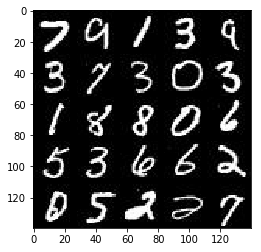

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

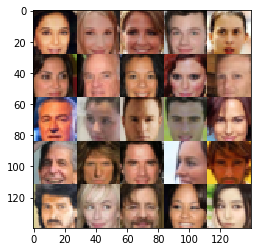

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name = 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #Assuming celeb: 28*28*3
        alpha = 0.01
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha*x1, x1)
        #Now 14*14*64  
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training= True)
        relu2 = tf.maximum(alpha*x2, x2)
        #Now 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 1, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training= True)
        relu3 = tf.maximum(alpha*x3, x3)
        #Now 7*7*256
        
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.01
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        #Now 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #Now 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #Now 14*14*128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #Now 28*28*3 or 28*28*1
        
        output = tf.nn.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    
    _, img_width, img_height, img_channels = data_shape
    real_inputs, z_inputs, lr = model_inputs( img_width, img_height, img_channels, z_dim)

    d_loss, g_loss = model_loss(real_inputs, z_inputs, img_channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images *=  2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}: \t".format(epoch_i+1, epoch_count),
                          "Batch {} -- \t".format(steps),
                          "Discriminator Loss: {:.4f} \t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, z_inputs, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2: 	 Batch 10 -- 	 Discriminator Loss: 0.7530 	 Generator Loss: 1.1312
Epoch 1/2: 	 Batch 20 -- 	 Discriminator Loss: 1.1039 	 Generator Loss: 0.7683
Epoch 1/2: 	 Batch 30 -- 	 Discriminator Loss: 1.0188 	 Generator Loss: 1.1983
Epoch 1/2: 	 Batch 40 -- 	 Discriminator Loss: 0.9888 	 Generator Loss: 1.2568
Epoch 1/2: 	 Batch 50 -- 	 Discriminator Loss: 1.2071 	 Generator Loss: 0.6063
Epoch 1/2: 	 Batch 60 -- 	 Discriminator Loss: 2.7307 	 Generator Loss: 0.1304
Epoch 1/2: 	 Batch 70 -- 	 Discriminator Loss: 0.8392 	 Generator Loss: 1.3397
Epoch 1/2: 	 Batch 80 -- 	 Discriminator Loss: 1.0219 	 Generator Loss: 1.0982
Epoch 1/2: 	 Batch 90 -- 	 Discriminator Loss: 1.1846 	 Generator Loss: 0.8735
Epoch 1/2: 	 Batch 100 -- 	 Discriminator Loss: 1.3693 	 Generator Loss: 0.7805


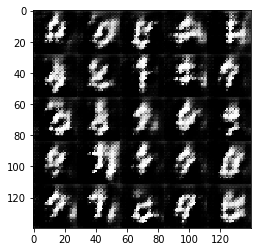

Epoch 1/2: 	 Batch 110 -- 	 Discriminator Loss: 1.1571 	 Generator Loss: 1.0469
Epoch 1/2: 	 Batch 120 -- 	 Discriminator Loss: 1.4801 	 Generator Loss: 1.0083
Epoch 1/2: 	 Batch 130 -- 	 Discriminator Loss: 1.3708 	 Generator Loss: 0.8380
Epoch 1/2: 	 Batch 140 -- 	 Discriminator Loss: 1.6022 	 Generator Loss: 1.7212
Epoch 1/2: 	 Batch 150 -- 	 Discriminator Loss: 1.0173 	 Generator Loss: 1.2561
Epoch 1/2: 	 Batch 160 -- 	 Discriminator Loss: 1.1432 	 Generator Loss: 0.8822
Epoch 1/2: 	 Batch 170 -- 	 Discriminator Loss: 1.1182 	 Generator Loss: 1.2422
Epoch 1/2: 	 Batch 180 -- 	 Discriminator Loss: 1.2364 	 Generator Loss: 1.0638
Epoch 1/2: 	 Batch 190 -- 	 Discriminator Loss: 1.5852 	 Generator Loss: 1.9801
Epoch 1/2: 	 Batch 200 -- 	 Discriminator Loss: 1.2036 	 Generator Loss: 0.9943


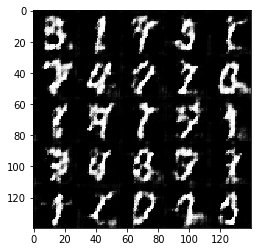

Epoch 1/2: 	 Batch 210 -- 	 Discriminator Loss: 1.2422 	 Generator Loss: 0.9580
Epoch 1/2: 	 Batch 220 -- 	 Discriminator Loss: 1.2109 	 Generator Loss: 1.0047
Epoch 1/2: 	 Batch 230 -- 	 Discriminator Loss: 1.3183 	 Generator Loss: 0.8472
Epoch 1/2: 	 Batch 240 -- 	 Discriminator Loss: 1.1994 	 Generator Loss: 0.9967
Epoch 1/2: 	 Batch 250 -- 	 Discriminator Loss: 1.3410 	 Generator Loss: 0.8754
Epoch 1/2: 	 Batch 260 -- 	 Discriminator Loss: 1.4487 	 Generator Loss: 0.8028
Epoch 1/2: 	 Batch 270 -- 	 Discriminator Loss: 1.5324 	 Generator Loss: 1.6104
Epoch 1/2: 	 Batch 280 -- 	 Discriminator Loss: 1.3307 	 Generator Loss: 0.7727
Epoch 1/2: 	 Batch 290 -- 	 Discriminator Loss: 1.2711 	 Generator Loss: 0.8381
Epoch 1/2: 	 Batch 300 -- 	 Discriminator Loss: 1.3654 	 Generator Loss: 0.7926


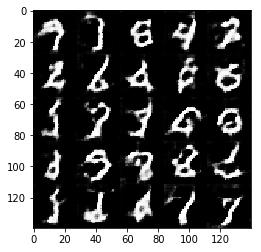

Epoch 1/2: 	 Batch 310 -- 	 Discriminator Loss: 1.0426 	 Generator Loss: 1.1379
Epoch 1/2: 	 Batch 320 -- 	 Discriminator Loss: 1.2525 	 Generator Loss: 0.8409
Epoch 1/2: 	 Batch 330 -- 	 Discriminator Loss: 1.2288 	 Generator Loss: 0.9427
Epoch 1/2: 	 Batch 340 -- 	 Discriminator Loss: 1.3134 	 Generator Loss: 0.8470
Epoch 1/2: 	 Batch 350 -- 	 Discriminator Loss: 1.2492 	 Generator Loss: 0.7768
Epoch 1/2: 	 Batch 360 -- 	 Discriminator Loss: 1.2958 	 Generator Loss: 0.7955
Epoch 1/2: 	 Batch 370 -- 	 Discriminator Loss: 1.3503 	 Generator Loss: 0.7374
Epoch 1/2: 	 Batch 380 -- 	 Discriminator Loss: 1.1495 	 Generator Loss: 1.0838
Epoch 1/2: 	 Batch 390 -- 	 Discriminator Loss: 1.4790 	 Generator Loss: 0.6329
Epoch 1/2: 	 Batch 400 -- 	 Discriminator Loss: 1.2764 	 Generator Loss: 0.7875


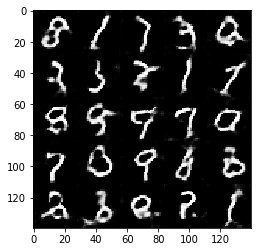

Epoch 1/2: 	 Batch 410 -- 	 Discriminator Loss: 1.2810 	 Generator Loss: 1.0067
Epoch 1/2: 	 Batch 420 -- 	 Discriminator Loss: 1.3582 	 Generator Loss: 0.7705
Epoch 1/2: 	 Batch 430 -- 	 Discriminator Loss: 1.2618 	 Generator Loss: 0.8520
Epoch 1/2: 	 Batch 440 -- 	 Discriminator Loss: 1.2799 	 Generator Loss: 0.9120
Epoch 1/2: 	 Batch 450 -- 	 Discriminator Loss: 1.3611 	 Generator Loss: 1.0026
Epoch 1/2: 	 Batch 460 -- 	 Discriminator Loss: 1.2206 	 Generator Loss: 0.7995
Epoch 1/2: 	 Batch 470 -- 	 Discriminator Loss: 1.1852 	 Generator Loss: 0.8799
Epoch 1/2: 	 Batch 480 -- 	 Discriminator Loss: 1.3325 	 Generator Loss: 0.8021
Epoch 1/2: 	 Batch 490 -- 	 Discriminator Loss: 1.2539 	 Generator Loss: 0.9403
Epoch 1/2: 	 Batch 500 -- 	 Discriminator Loss: 1.1938 	 Generator Loss: 0.9166


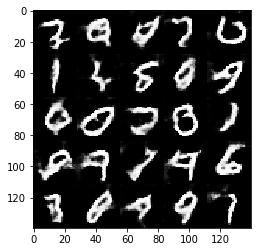

Epoch 1/2: 	 Batch 510 -- 	 Discriminator Loss: 1.2676 	 Generator Loss: 0.8666
Epoch 1/2: 	 Batch 520 -- 	 Discriminator Loss: 1.1660 	 Generator Loss: 0.9334
Epoch 1/2: 	 Batch 530 -- 	 Discriminator Loss: 1.3514 	 Generator Loss: 0.6985
Epoch 1/2: 	 Batch 540 -- 	 Discriminator Loss: 1.3480 	 Generator Loss: 0.7230
Epoch 1/2: 	 Batch 550 -- 	 Discriminator Loss: 1.2202 	 Generator Loss: 0.9542
Epoch 1/2: 	 Batch 560 -- 	 Discriminator Loss: 1.2778 	 Generator Loss: 0.8582
Epoch 1/2: 	 Batch 570 -- 	 Discriminator Loss: 1.2367 	 Generator Loss: 0.9043
Epoch 1/2: 	 Batch 580 -- 	 Discriminator Loss: 1.1456 	 Generator Loss: 1.0223
Epoch 1/2: 	 Batch 590 -- 	 Discriminator Loss: 1.3802 	 Generator Loss: 0.8087
Epoch 1/2: 	 Batch 600 -- 	 Discriminator Loss: 1.1344 	 Generator Loss: 1.0610


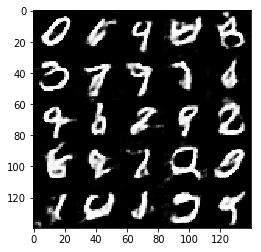

Epoch 1/2: 	 Batch 610 -- 	 Discriminator Loss: 1.2390 	 Generator Loss: 0.9276
Epoch 1/2: 	 Batch 620 -- 	 Discriminator Loss: 1.3240 	 Generator Loss: 0.8007
Epoch 1/2: 	 Batch 630 -- 	 Discriminator Loss: 1.1649 	 Generator Loss: 1.0309
Epoch 1/2: 	 Batch 640 -- 	 Discriminator Loss: 1.2379 	 Generator Loss: 0.9293
Epoch 1/2: 	 Batch 650 -- 	 Discriminator Loss: 1.3256 	 Generator Loss: 0.8355
Epoch 1/2: 	 Batch 660 -- 	 Discriminator Loss: 1.1123 	 Generator Loss: 0.9364
Epoch 1/2: 	 Batch 670 -- 	 Discriminator Loss: 1.2597 	 Generator Loss: 1.0875
Epoch 1/2: 	 Batch 680 -- 	 Discriminator Loss: 1.2383 	 Generator Loss: 0.9008
Epoch 1/2: 	 Batch 690 -- 	 Discriminator Loss: 1.2953 	 Generator Loss: 0.9372
Epoch 1/2: 	 Batch 700 -- 	 Discriminator Loss: 1.2098 	 Generator Loss: 0.8979


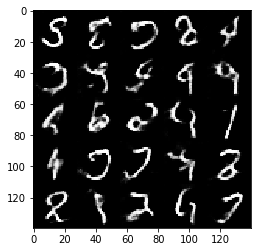

Epoch 1/2: 	 Batch 710 -- 	 Discriminator Loss: 1.2133 	 Generator Loss: 0.9809
Epoch 1/2: 	 Batch 720 -- 	 Discriminator Loss: 1.3037 	 Generator Loss: 0.8047
Epoch 1/2: 	 Batch 730 -- 	 Discriminator Loss: 1.2581 	 Generator Loss: 0.9141
Epoch 1/2: 	 Batch 740 -- 	 Discriminator Loss: 1.2741 	 Generator Loss: 0.7676
Epoch 1/2: 	 Batch 750 -- 	 Discriminator Loss: 1.1950 	 Generator Loss: 0.9848
Epoch 1/2: 	 Batch 760 -- 	 Discriminator Loss: 1.2102 	 Generator Loss: 0.9725
Epoch 1/2: 	 Batch 770 -- 	 Discriminator Loss: 1.2481 	 Generator Loss: 0.8326
Epoch 1/2: 	 Batch 780 -- 	 Discriminator Loss: 1.2027 	 Generator Loss: 1.0852
Epoch 1/2: 	 Batch 790 -- 	 Discriminator Loss: 1.2909 	 Generator Loss: 0.9673
Epoch 1/2: 	 Batch 800 -- 	 Discriminator Loss: 1.1832 	 Generator Loss: 0.9495


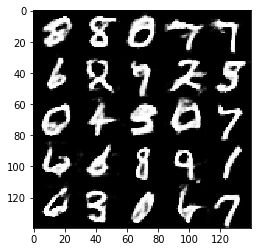

Epoch 1/2: 	 Batch 810 -- 	 Discriminator Loss: 1.2975 	 Generator Loss: 0.8366
Epoch 1/2: 	 Batch 820 -- 	 Discriminator Loss: 1.3476 	 Generator Loss: 0.7579
Epoch 1/2: 	 Batch 830 -- 	 Discriminator Loss: 1.1272 	 Generator Loss: 0.9336
Epoch 1/2: 	 Batch 840 -- 	 Discriminator Loss: 1.4090 	 Generator Loss: 0.7812
Epoch 1/2: 	 Batch 850 -- 	 Discriminator Loss: 1.2792 	 Generator Loss: 0.7991
Epoch 1/2: 	 Batch 860 -- 	 Discriminator Loss: 1.0750 	 Generator Loss: 1.0586
Epoch 1/2: 	 Batch 870 -- 	 Discriminator Loss: 1.3929 	 Generator Loss: 0.7462
Epoch 1/2: 	 Batch 880 -- 	 Discriminator Loss: 1.1525 	 Generator Loss: 1.0659
Epoch 1/2: 	 Batch 890 -- 	 Discriminator Loss: 1.1978 	 Generator Loss: 0.9121
Epoch 1/2: 	 Batch 900 -- 	 Discriminator Loss: 1.1971 	 Generator Loss: 0.9367


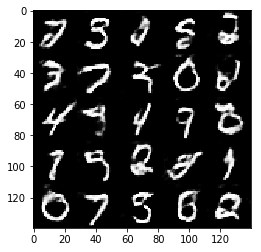

Epoch 1/2: 	 Batch 910 -- 	 Discriminator Loss: 1.2869 	 Generator Loss: 0.7748
Epoch 1/2: 	 Batch 920 -- 	 Discriminator Loss: 1.1737 	 Generator Loss: 0.8693
Epoch 1/2: 	 Batch 930 -- 	 Discriminator Loss: 1.2797 	 Generator Loss: 0.8233
Epoch 2/2: 	 Batch 10 -- 	 Discriminator Loss: 1.2142 	 Generator Loss: 1.0122
Epoch 2/2: 	 Batch 20 -- 	 Discriminator Loss: 1.1883 	 Generator Loss: 0.8890
Epoch 2/2: 	 Batch 30 -- 	 Discriminator Loss: 1.1811 	 Generator Loss: 0.9004
Epoch 2/2: 	 Batch 40 -- 	 Discriminator Loss: 1.3754 	 Generator Loss: 0.8180
Epoch 2/2: 	 Batch 50 -- 	 Discriminator Loss: 1.3159 	 Generator Loss: 0.8697
Epoch 2/2: 	 Batch 60 -- 	 Discriminator Loss: 1.3158 	 Generator Loss: 0.7292
Epoch 2/2: 	 Batch 70 -- 	 Discriminator Loss: 1.3155 	 Generator Loss: 0.7430
Epoch 2/2: 	 Batch 80 -- 	 Discriminator Loss: 1.1906 	 Generator Loss: 0.9517
Epoch 2/2: 	 Batch 90 -- 	 Discriminator Loss: 1.3304 	 Generator Loss: 0.9455
Epoch 2/2: 	 Batch 100 -- 	 Discriminator Loss: 1

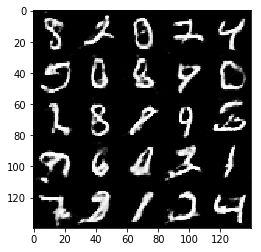

Epoch 2/2: 	 Batch 110 -- 	 Discriminator Loss: 1.2608 	 Generator Loss: 0.7387
Epoch 2/2: 	 Batch 120 -- 	 Discriminator Loss: 1.2404 	 Generator Loss: 0.8352
Epoch 2/2: 	 Batch 130 -- 	 Discriminator Loss: 1.1205 	 Generator Loss: 0.9502
Epoch 2/2: 	 Batch 140 -- 	 Discriminator Loss: 1.2001 	 Generator Loss: 0.9158
Epoch 2/2: 	 Batch 150 -- 	 Discriminator Loss: 1.1979 	 Generator Loss: 0.9313
Epoch 2/2: 	 Batch 160 -- 	 Discriminator Loss: 1.2431 	 Generator Loss: 0.8108
Epoch 2/2: 	 Batch 170 -- 	 Discriminator Loss: 1.2678 	 Generator Loss: 0.8499
Epoch 2/2: 	 Batch 180 -- 	 Discriminator Loss: 1.3314 	 Generator Loss: 0.7687
Epoch 2/2: 	 Batch 190 -- 	 Discriminator Loss: 1.2198 	 Generator Loss: 0.8686
Epoch 2/2: 	 Batch 200 -- 	 Discriminator Loss: 1.2148 	 Generator Loss: 0.8502


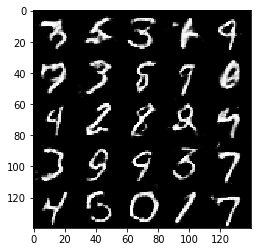

Epoch 2/2: 	 Batch 210 -- 	 Discriminator Loss: 1.3527 	 Generator Loss: 0.8164
Epoch 2/2: 	 Batch 220 -- 	 Discriminator Loss: 1.2889 	 Generator Loss: 0.8231
Epoch 2/2: 	 Batch 230 -- 	 Discriminator Loss: 1.2534 	 Generator Loss: 0.8747
Epoch 2/2: 	 Batch 240 -- 	 Discriminator Loss: 1.2010 	 Generator Loss: 0.8811
Epoch 2/2: 	 Batch 250 -- 	 Discriminator Loss: 1.2236 	 Generator Loss: 0.9847
Epoch 2/2: 	 Batch 260 -- 	 Discriminator Loss: 1.1976 	 Generator Loss: 1.0461
Epoch 2/2: 	 Batch 270 -- 	 Discriminator Loss: 1.2787 	 Generator Loss: 0.8582
Epoch 2/2: 	 Batch 280 -- 	 Discriminator Loss: 1.2021 	 Generator Loss: 0.8988
Epoch 2/2: 	 Batch 290 -- 	 Discriminator Loss: 1.2726 	 Generator Loss: 0.8310
Epoch 2/2: 	 Batch 300 -- 	 Discriminator Loss: 1.1753 	 Generator Loss: 0.8872


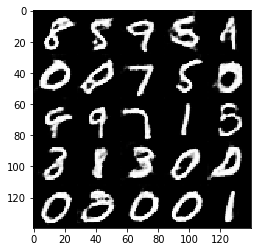

Epoch 2/2: 	 Batch 310 -- 	 Discriminator Loss: 1.3481 	 Generator Loss: 0.7532
Epoch 2/2: 	 Batch 320 -- 	 Discriminator Loss: 1.3111 	 Generator Loss: 0.8504
Epoch 2/2: 	 Batch 330 -- 	 Discriminator Loss: 1.2307 	 Generator Loss: 0.9008
Epoch 2/2: 	 Batch 340 -- 	 Discriminator Loss: 1.2424 	 Generator Loss: 0.8932
Epoch 2/2: 	 Batch 350 -- 	 Discriminator Loss: 1.2199 	 Generator Loss: 0.9027
Epoch 2/2: 	 Batch 360 -- 	 Discriminator Loss: 1.2461 	 Generator Loss: 0.8674
Epoch 2/2: 	 Batch 370 -- 	 Discriminator Loss: 1.3143 	 Generator Loss: 0.8256
Epoch 2/2: 	 Batch 380 -- 	 Discriminator Loss: 1.1450 	 Generator Loss: 0.9713
Epoch 2/2: 	 Batch 390 -- 	 Discriminator Loss: 1.2400 	 Generator Loss: 0.8579
Epoch 2/2: 	 Batch 400 -- 	 Discriminator Loss: 1.2223 	 Generator Loss: 0.8525


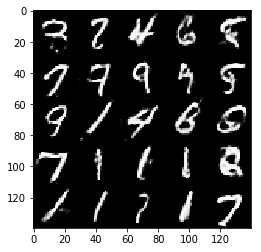

Epoch 2/2: 	 Batch 410 -- 	 Discriminator Loss: 1.2744 	 Generator Loss: 0.7318
Epoch 2/2: 	 Batch 420 -- 	 Discriminator Loss: 1.2367 	 Generator Loss: 1.1161
Epoch 2/2: 	 Batch 430 -- 	 Discriminator Loss: 1.2708 	 Generator Loss: 0.8661
Epoch 2/2: 	 Batch 440 -- 	 Discriminator Loss: 1.1236 	 Generator Loss: 0.9720
Epoch 2/2: 	 Batch 450 -- 	 Discriminator Loss: 1.2145 	 Generator Loss: 0.8945
Epoch 2/2: 	 Batch 460 -- 	 Discriminator Loss: 1.2512 	 Generator Loss: 0.8598
Epoch 2/2: 	 Batch 470 -- 	 Discriminator Loss: 1.2946 	 Generator Loss: 0.8705
Epoch 2/2: 	 Batch 480 -- 	 Discriminator Loss: 1.1820 	 Generator Loss: 0.9102
Epoch 2/2: 	 Batch 490 -- 	 Discriminator Loss: 1.3378 	 Generator Loss: 0.9355
Epoch 2/2: 	 Batch 500 -- 	 Discriminator Loss: 1.1868 	 Generator Loss: 0.9059


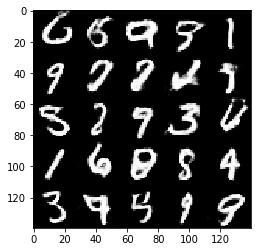

Epoch 2/2: 	 Batch 510 -- 	 Discriminator Loss: 1.2063 	 Generator Loss: 0.9111
Epoch 2/2: 	 Batch 520 -- 	 Discriminator Loss: 1.2544 	 Generator Loss: 0.7853
Epoch 2/2: 	 Batch 530 -- 	 Discriminator Loss: 1.1989 	 Generator Loss: 1.0208
Epoch 2/2: 	 Batch 540 -- 	 Discriminator Loss: 1.3522 	 Generator Loss: 0.7655
Epoch 2/2: 	 Batch 550 -- 	 Discriminator Loss: 1.2333 	 Generator Loss: 0.9148
Epoch 2/2: 	 Batch 560 -- 	 Discriminator Loss: 1.2205 	 Generator Loss: 0.9007
Epoch 2/2: 	 Batch 570 -- 	 Discriminator Loss: 1.1800 	 Generator Loss: 1.0000
Epoch 2/2: 	 Batch 580 -- 	 Discriminator Loss: 1.3807 	 Generator Loss: 0.6255
Epoch 2/2: 	 Batch 590 -- 	 Discriminator Loss: 1.2567 	 Generator Loss: 0.8648
Epoch 2/2: 	 Batch 600 -- 	 Discriminator Loss: 1.1660 	 Generator Loss: 0.9851


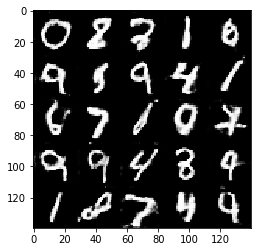

Epoch 2/2: 	 Batch 610 -- 	 Discriminator Loss: 1.1956 	 Generator Loss: 0.8272
Epoch 2/2: 	 Batch 620 -- 	 Discriminator Loss: 1.1673 	 Generator Loss: 0.9730
Epoch 2/2: 	 Batch 630 -- 	 Discriminator Loss: 1.1201 	 Generator Loss: 1.0114
Epoch 2/2: 	 Batch 640 -- 	 Discriminator Loss: 1.2662 	 Generator Loss: 1.0163
Epoch 2/2: 	 Batch 650 -- 	 Discriminator Loss: 1.2102 	 Generator Loss: 0.9707
Epoch 2/2: 	 Batch 660 -- 	 Discriminator Loss: 1.1736 	 Generator Loss: 0.9460
Epoch 2/2: 	 Batch 670 -- 	 Discriminator Loss: 1.2412 	 Generator Loss: 0.9338
Epoch 2/2: 	 Batch 680 -- 	 Discriminator Loss: 1.1396 	 Generator Loss: 1.1200
Epoch 2/2: 	 Batch 690 -- 	 Discriminator Loss: 1.2375 	 Generator Loss: 0.9278
Epoch 2/2: 	 Batch 700 -- 	 Discriminator Loss: 1.1672 	 Generator Loss: 0.8492


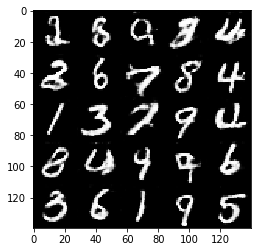

Epoch 2/2: 	 Batch 710 -- 	 Discriminator Loss: 1.2278 	 Generator Loss: 0.9751
Epoch 2/2: 	 Batch 720 -- 	 Discriminator Loss: 1.2411 	 Generator Loss: 0.8551
Epoch 2/2: 	 Batch 730 -- 	 Discriminator Loss: 1.1992 	 Generator Loss: 0.8193
Epoch 2/2: 	 Batch 740 -- 	 Discriminator Loss: 1.3101 	 Generator Loss: 0.6581
Epoch 2/2: 	 Batch 750 -- 	 Discriminator Loss: 1.2806 	 Generator Loss: 0.8078
Epoch 2/2: 	 Batch 760 -- 	 Discriminator Loss: 1.2434 	 Generator Loss: 0.8054
Epoch 2/2: 	 Batch 770 -- 	 Discriminator Loss: 1.0466 	 Generator Loss: 1.2212
Epoch 2/2: 	 Batch 780 -- 	 Discriminator Loss: 1.0951 	 Generator Loss: 1.1132
Epoch 2/2: 	 Batch 790 -- 	 Discriminator Loss: 1.2987 	 Generator Loss: 0.8082
Epoch 2/2: 	 Batch 800 -- 	 Discriminator Loss: 1.1703 	 Generator Loss: 0.9180


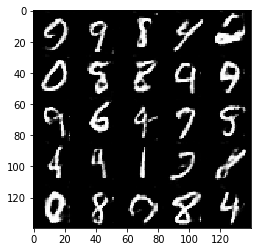

Epoch 2/2: 	 Batch 810 -- 	 Discriminator Loss: 1.1994 	 Generator Loss: 0.8130
Epoch 2/2: 	 Batch 820 -- 	 Discriminator Loss: 1.2383 	 Generator Loss: 0.9361
Epoch 2/2: 	 Batch 830 -- 	 Discriminator Loss: 1.2255 	 Generator Loss: 0.8871
Epoch 2/2: 	 Batch 840 -- 	 Discriminator Loss: 1.2340 	 Generator Loss: 0.8848
Epoch 2/2: 	 Batch 850 -- 	 Discriminator Loss: 1.2525 	 Generator Loss: 0.8736
Epoch 2/2: 	 Batch 860 -- 	 Discriminator Loss: 1.2515 	 Generator Loss: 0.7135
Epoch 2/2: 	 Batch 870 -- 	 Discriminator Loss: 1.2670 	 Generator Loss: 0.7841
Epoch 2/2: 	 Batch 880 -- 	 Discriminator Loss: 1.1404 	 Generator Loss: 1.1287
Epoch 2/2: 	 Batch 890 -- 	 Discriminator Loss: 1.2726 	 Generator Loss: 0.9188
Epoch 2/2: 	 Batch 900 -- 	 Discriminator Loss: 1.2039 	 Generator Loss: 1.0259


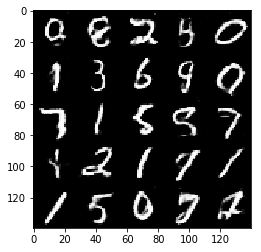

Epoch 2/2: 	 Batch 910 -- 	 Discriminator Loss: 1.2974 	 Generator Loss: 0.9927
Epoch 2/2: 	 Batch 920 -- 	 Discriminator Loss: 1.2502 	 Generator Loss: 0.8088
Epoch 2/2: 	 Batch 930 -- 	 Discriminator Loss: 1.1008 	 Generator Loss: 1.1971


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1: 	 Batch 10 -- 	 Discriminator Loss: 1.0573 	 Generator Loss: 0.7843
Epoch 1/1: 	 Batch 20 -- 	 Discriminator Loss: 1.3425 	 Generator Loss: 1.6747
Epoch 1/1: 	 Batch 30 -- 	 Discriminator Loss: 1.6468 	 Generator Loss: 1.8960
Epoch 1/1: 	 Batch 40 -- 	 Discriminator Loss: 1.2925 	 Generator Loss: 0.9165
Epoch 1/1: 	 Batch 50 -- 	 Discriminator Loss: 1.3681 	 Generator Loss: 0.7652
Epoch 1/1: 	 Batch 60 -- 	 Discriminator Loss: 1.5337 	 Generator Loss: 0.5305
Epoch 1/1: 	 Batch 70 -- 	 Discriminator Loss: 1.5722 	 Generator Loss: 0.5871
Epoch 1/1: 	 Batch 80 -- 	 Discriminator Loss: 1.2457 	 Generator Loss: 0.8627
Epoch 1/1: 	 Batch 90 -- 	 Discriminator Loss: 1.3206 	 Generator Loss: 0.9687
Epoch 1/1: 	 Batch 100 -- 	 Discriminator Loss: 1.4572 	 Generator Loss: 0.6135


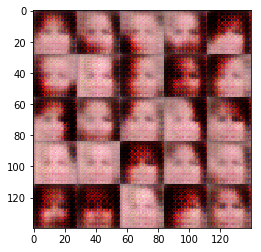

Epoch 1/1: 	 Batch 110 -- 	 Discriminator Loss: 1.1349 	 Generator Loss: 0.9729
Epoch 1/1: 	 Batch 120 -- 	 Discriminator Loss: 1.2353 	 Generator Loss: 0.8739
Epoch 1/1: 	 Batch 130 -- 	 Discriminator Loss: 1.4833 	 Generator Loss: 0.7452
Epoch 1/1: 	 Batch 140 -- 	 Discriminator Loss: 1.2975 	 Generator Loss: 0.7744
Epoch 1/1: 	 Batch 150 -- 	 Discriminator Loss: 1.2339 	 Generator Loss: 0.7747
Epoch 1/1: 	 Batch 160 -- 	 Discriminator Loss: 1.2049 	 Generator Loss: 0.7931
Epoch 1/1: 	 Batch 170 -- 	 Discriminator Loss: 1.6185 	 Generator Loss: 1.2539
Epoch 1/1: 	 Batch 180 -- 	 Discriminator Loss: 1.3311 	 Generator Loss: 0.8066
Epoch 1/1: 	 Batch 190 -- 	 Discriminator Loss: 1.6018 	 Generator Loss: 1.0776
Epoch 1/1: 	 Batch 200 -- 	 Discriminator Loss: 1.2167 	 Generator Loss: 0.8683


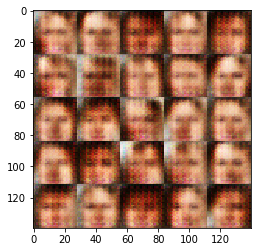

Epoch 1/1: 	 Batch 210 -- 	 Discriminator Loss: 1.2758 	 Generator Loss: 0.8317
Epoch 1/1: 	 Batch 220 -- 	 Discriminator Loss: 1.2231 	 Generator Loss: 0.8250
Epoch 1/1: 	 Batch 230 -- 	 Discriminator Loss: 1.2284 	 Generator Loss: 0.8695
Epoch 1/1: 	 Batch 240 -- 	 Discriminator Loss: 1.4085 	 Generator Loss: 0.8530
Epoch 1/1: 	 Batch 250 -- 	 Discriminator Loss: 1.1366 	 Generator Loss: 1.0028
Epoch 1/1: 	 Batch 260 -- 	 Discriminator Loss: 1.2162 	 Generator Loss: 0.9673
Epoch 1/1: 	 Batch 270 -- 	 Discriminator Loss: 1.4028 	 Generator Loss: 0.6318
Epoch 1/1: 	 Batch 280 -- 	 Discriminator Loss: 1.1992 	 Generator Loss: 0.9998
Epoch 1/1: 	 Batch 290 -- 	 Discriminator Loss: 1.1937 	 Generator Loss: 0.8671
Epoch 1/1: 	 Batch 300 -- 	 Discriminator Loss: 1.3305 	 Generator Loss: 0.6693


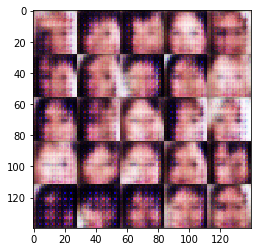

Epoch 1/1: 	 Batch 310 -- 	 Discriminator Loss: 1.2313 	 Generator Loss: 0.9569
Epoch 1/1: 	 Batch 320 -- 	 Discriminator Loss: 1.2121 	 Generator Loss: 0.8898
Epoch 1/1: 	 Batch 330 -- 	 Discriminator Loss: 1.9327 	 Generator Loss: 3.1236
Epoch 1/1: 	 Batch 340 -- 	 Discriminator Loss: 1.0711 	 Generator Loss: 1.1451
Epoch 1/1: 	 Batch 350 -- 	 Discriminator Loss: 1.1457 	 Generator Loss: 1.0485
Epoch 1/1: 	 Batch 360 -- 	 Discriminator Loss: 1.3622 	 Generator Loss: 0.9696
Epoch 1/1: 	 Batch 370 -- 	 Discriminator Loss: 1.3591 	 Generator Loss: 1.2168
Epoch 1/1: 	 Batch 380 -- 	 Discriminator Loss: 1.6027 	 Generator Loss: 1.0882
Epoch 1/1: 	 Batch 390 -- 	 Discriminator Loss: 1.2413 	 Generator Loss: 1.0095
Epoch 1/1: 	 Batch 400 -- 	 Discriminator Loss: 1.0308 	 Generator Loss: 2.5337


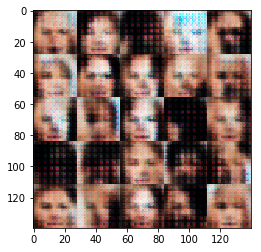

Epoch 1/1: 	 Batch 410 -- 	 Discriminator Loss: 1.2492 	 Generator Loss: 0.9364
Epoch 1/1: 	 Batch 420 -- 	 Discriminator Loss: 1.2269 	 Generator Loss: 1.2012
Epoch 1/1: 	 Batch 430 -- 	 Discriminator Loss: 0.6555 	 Generator Loss: 2.1001
Epoch 1/1: 	 Batch 440 -- 	 Discriminator Loss: 1.4406 	 Generator Loss: 0.6142
Epoch 1/1: 	 Batch 450 -- 	 Discriminator Loss: 1.1994 	 Generator Loss: 1.1801
Epoch 1/1: 	 Batch 460 -- 	 Discriminator Loss: 1.3873 	 Generator Loss: 0.8990
Epoch 1/1: 	 Batch 470 -- 	 Discriminator Loss: 1.1202 	 Generator Loss: 0.8403
Epoch 1/1: 	 Batch 480 -- 	 Discriminator Loss: 1.2647 	 Generator Loss: 0.7530
Epoch 1/1: 	 Batch 490 -- 	 Discriminator Loss: 1.1398 	 Generator Loss: 1.3125
Epoch 1/1: 	 Batch 500 -- 	 Discriminator Loss: 1.1561 	 Generator Loss: 0.8535


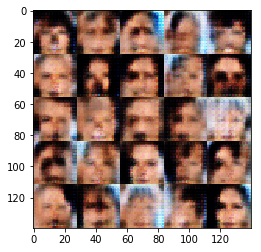

Epoch 1/1: 	 Batch 510 -- 	 Discriminator Loss: 1.1124 	 Generator Loss: 1.1764
Epoch 1/1: 	 Batch 520 -- 	 Discriminator Loss: 0.9590 	 Generator Loss: 1.1526
Epoch 1/1: 	 Batch 530 -- 	 Discriminator Loss: 1.1570 	 Generator Loss: 0.8966
Epoch 1/1: 	 Batch 540 -- 	 Discriminator Loss: 0.4593 	 Generator Loss: 3.6515
Epoch 1/1: 	 Batch 550 -- 	 Discriminator Loss: 1.1017 	 Generator Loss: 1.1505
Epoch 1/1: 	 Batch 560 -- 	 Discriminator Loss: 1.2968 	 Generator Loss: 0.8892
Epoch 1/1: 	 Batch 570 -- 	 Discriminator Loss: 1.3346 	 Generator Loss: 0.8001
Epoch 1/1: 	 Batch 580 -- 	 Discriminator Loss: 1.2774 	 Generator Loss: 0.7438
Epoch 1/1: 	 Batch 590 -- 	 Discriminator Loss: 1.2880 	 Generator Loss: 0.8253
Epoch 1/1: 	 Batch 600 -- 	 Discriminator Loss: 1.2573 	 Generator Loss: 0.9584


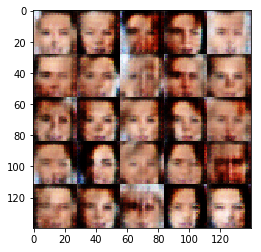

Epoch 1/1: 	 Batch 610 -- 	 Discriminator Loss: 0.6834 	 Generator Loss: 1.5969
Epoch 1/1: 	 Batch 620 -- 	 Discriminator Loss: 1.2876 	 Generator Loss: 0.8082
Epoch 1/1: 	 Batch 630 -- 	 Discriminator Loss: 1.2310 	 Generator Loss: 1.2174
Epoch 1/1: 	 Batch 640 -- 	 Discriminator Loss: 1.2501 	 Generator Loss: 0.7923
Epoch 1/1: 	 Batch 650 -- 	 Discriminator Loss: 0.6609 	 Generator Loss: 1.4439
Epoch 1/1: 	 Batch 660 -- 	 Discriminator Loss: 1.1712 	 Generator Loss: 1.0089
Epoch 1/1: 	 Batch 670 -- 	 Discriminator Loss: 1.2726 	 Generator Loss: 0.8265
Epoch 1/1: 	 Batch 680 -- 	 Discriminator Loss: 1.0329 	 Generator Loss: 0.9613
Epoch 1/1: 	 Batch 690 -- 	 Discriminator Loss: 1.2021 	 Generator Loss: 0.8705
Epoch 1/1: 	 Batch 700 -- 	 Discriminator Loss: 0.9446 	 Generator Loss: 1.1752


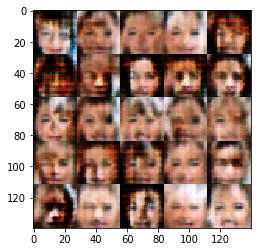

Epoch 1/1: 	 Batch 710 -- 	 Discriminator Loss: 1.1465 	 Generator Loss: 1.1800
Epoch 1/1: 	 Batch 720 -- 	 Discriminator Loss: 1.1264 	 Generator Loss: 1.1624
Epoch 1/1: 	 Batch 730 -- 	 Discriminator Loss: 0.8804 	 Generator Loss: 1.4403
Epoch 1/1: 	 Batch 740 -- 	 Discriminator Loss: 1.0455 	 Generator Loss: 1.1649
Epoch 1/1: 	 Batch 750 -- 	 Discriminator Loss: 1.2062 	 Generator Loss: 0.9343
Epoch 1/1: 	 Batch 760 -- 	 Discriminator Loss: 1.0503 	 Generator Loss: 1.0349
Epoch 1/1: 	 Batch 770 -- 	 Discriminator Loss: 1.0434 	 Generator Loss: 1.0645
Epoch 1/1: 	 Batch 780 -- 	 Discriminator Loss: 1.4130 	 Generator Loss: 1.4885
Epoch 1/1: 	 Batch 790 -- 	 Discriminator Loss: 1.1029 	 Generator Loss: 1.0953
Epoch 1/1: 	 Batch 800 -- 	 Discriminator Loss: 0.9978 	 Generator Loss: 1.1122


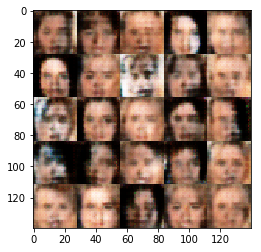

Epoch 1/1: 	 Batch 810 -- 	 Discriminator Loss: 2.3823 	 Generator Loss: 2.8692
Epoch 1/1: 	 Batch 820 -- 	 Discriminator Loss: 1.1532 	 Generator Loss: 0.9607
Epoch 1/1: 	 Batch 830 -- 	 Discriminator Loss: 1.0387 	 Generator Loss: 1.0132
Epoch 1/1: 	 Batch 840 -- 	 Discriminator Loss: 1.1087 	 Generator Loss: 0.8826
Epoch 1/1: 	 Batch 850 -- 	 Discriminator Loss: 2.0694 	 Generator Loss: 2.3374
Epoch 1/1: 	 Batch 860 -- 	 Discriminator Loss: 1.0448 	 Generator Loss: 0.9203
Epoch 1/1: 	 Batch 870 -- 	 Discriminator Loss: 1.1171 	 Generator Loss: 0.8865
Epoch 1/1: 	 Batch 880 -- 	 Discriminator Loss: 1.1718 	 Generator Loss: 0.7955
Epoch 1/1: 	 Batch 890 -- 	 Discriminator Loss: 1.1597 	 Generator Loss: 0.8559
Epoch 1/1: 	 Batch 900 -- 	 Discriminator Loss: 0.7404 	 Generator Loss: 1.3512


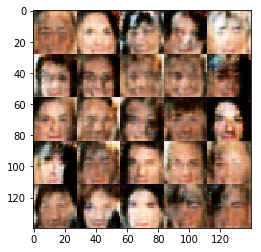

Epoch 1/1: 	 Batch 910 -- 	 Discriminator Loss: 0.9756 	 Generator Loss: 0.9442
Epoch 1/1: 	 Batch 920 -- 	 Discriminator Loss: 1.2323 	 Generator Loss: 0.8800
Epoch 1/1: 	 Batch 930 -- 	 Discriminator Loss: 1.2227 	 Generator Loss: 0.8734
Epoch 1/1: 	 Batch 940 -- 	 Discriminator Loss: 1.3552 	 Generator Loss: 0.8523
Epoch 1/1: 	 Batch 950 -- 	 Discriminator Loss: 1.0713 	 Generator Loss: 0.9106
Epoch 1/1: 	 Batch 960 -- 	 Discriminator Loss: 1.1962 	 Generator Loss: 1.5174
Epoch 1/1: 	 Batch 970 -- 	 Discriminator Loss: 1.1692 	 Generator Loss: 1.0098
Epoch 1/1: 	 Batch 980 -- 	 Discriminator Loss: 1.2056 	 Generator Loss: 1.3221
Epoch 1/1: 	 Batch 990 -- 	 Discriminator Loss: 1.2932 	 Generator Loss: 0.9102
Epoch 1/1: 	 Batch 1000 -- 	 Discriminator Loss: 1.3975 	 Generator Loss: 0.6019


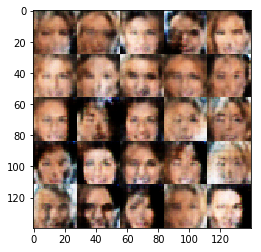

Epoch 1/1: 	 Batch 1010 -- 	 Discriminator Loss: 1.2173 	 Generator Loss: 0.9415
Epoch 1/1: 	 Batch 1020 -- 	 Discriminator Loss: 1.3320 	 Generator Loss: 1.0333
Epoch 1/1: 	 Batch 1030 -- 	 Discriminator Loss: 1.3305 	 Generator Loss: 0.9061
Epoch 1/1: 	 Batch 1040 -- 	 Discriminator Loss: 1.4498 	 Generator Loss: 1.8163
Epoch 1/1: 	 Batch 1050 -- 	 Discriminator Loss: 1.2727 	 Generator Loss: 0.8745
Epoch 1/1: 	 Batch 1060 -- 	 Discriminator Loss: 1.2471 	 Generator Loss: 1.2981
Epoch 1/1: 	 Batch 1070 -- 	 Discriminator Loss: 1.0809 	 Generator Loss: 0.9553
Epoch 1/1: 	 Batch 1080 -- 	 Discriminator Loss: 0.8966 	 Generator Loss: 1.3447
Epoch 1/1: 	 Batch 1090 -- 	 Discriminator Loss: 1.2865 	 Generator Loss: 0.7891
Epoch 1/1: 	 Batch 1100 -- 	 Discriminator Loss: 1.1764 	 Generator Loss: 1.0187


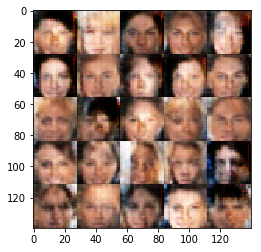

Epoch 1/1: 	 Batch 1110 -- 	 Discriminator Loss: 1.2356 	 Generator Loss: 1.3506
Epoch 1/1: 	 Batch 1120 -- 	 Discriminator Loss: 1.4068 	 Generator Loss: 0.5843
Epoch 1/1: 	 Batch 1130 -- 	 Discriminator Loss: 1.9997 	 Generator Loss: 2.6610
Epoch 1/1: 	 Batch 1140 -- 	 Discriminator Loss: 1.2147 	 Generator Loss: 1.0211
Epoch 1/1: 	 Batch 1150 -- 	 Discriminator Loss: 1.1674 	 Generator Loss: 1.0514
Epoch 1/1: 	 Batch 1160 -- 	 Discriminator Loss: 1.0021 	 Generator Loss: 1.3365
Epoch 1/1: 	 Batch 1170 -- 	 Discriminator Loss: 1.3180 	 Generator Loss: 0.8008
Epoch 1/1: 	 Batch 1180 -- 	 Discriminator Loss: 1.2604 	 Generator Loss: 0.8677
Epoch 1/1: 	 Batch 1190 -- 	 Discriminator Loss: 1.2285 	 Generator Loss: 0.8677
Epoch 1/1: 	 Batch 1200 -- 	 Discriminator Loss: 1.2570 	 Generator Loss: 0.8743


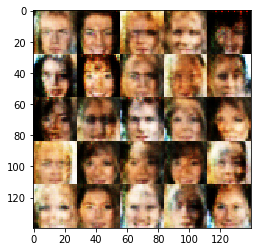

Epoch 1/1: 	 Batch 1210 -- 	 Discriminator Loss: 1.2977 	 Generator Loss: 0.8907
Epoch 1/1: 	 Batch 1220 -- 	 Discriminator Loss: 1.3033 	 Generator Loss: 0.8602
Epoch 1/1: 	 Batch 1230 -- 	 Discriminator Loss: 1.2349 	 Generator Loss: 0.7318
Epoch 1/1: 	 Batch 1240 -- 	 Discriminator Loss: 1.3833 	 Generator Loss: 1.2761
Epoch 1/1: 	 Batch 1250 -- 	 Discriminator Loss: 1.1494 	 Generator Loss: 0.9684
Epoch 1/1: 	 Batch 1260 -- 	 Discriminator Loss: 1.3445 	 Generator Loss: 0.8311
Epoch 1/1: 	 Batch 1270 -- 	 Discriminator Loss: 1.2842 	 Generator Loss: 0.8447
Epoch 1/1: 	 Batch 1280 -- 	 Discriminator Loss: 1.3258 	 Generator Loss: 0.8098
Epoch 1/1: 	 Batch 1290 -- 	 Discriminator Loss: 1.1475 	 Generator Loss: 0.8813
Epoch 1/1: 	 Batch 1300 -- 	 Discriminator Loss: 1.1989 	 Generator Loss: 0.9216


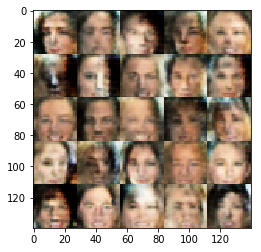

Epoch 1/1: 	 Batch 1310 -- 	 Discriminator Loss: 1.4693 	 Generator Loss: 1.3308
Epoch 1/1: 	 Batch 1320 -- 	 Discriminator Loss: 1.1369 	 Generator Loss: 0.9992
Epoch 1/1: 	 Batch 1330 -- 	 Discriminator Loss: 1.3608 	 Generator Loss: 0.7696
Epoch 1/1: 	 Batch 1340 -- 	 Discriminator Loss: 1.3739 	 Generator Loss: 0.8287
Epoch 1/1: 	 Batch 1350 -- 	 Discriminator Loss: 1.3121 	 Generator Loss: 0.8272
Epoch 1/1: 	 Batch 1360 -- 	 Discriminator Loss: 1.2961 	 Generator Loss: 0.8536
Epoch 1/1: 	 Batch 1370 -- 	 Discriminator Loss: 1.2218 	 Generator Loss: 0.8072
Epoch 1/1: 	 Batch 1380 -- 	 Discriminator Loss: 1.2106 	 Generator Loss: 0.8173
Epoch 1/1: 	 Batch 1390 -- 	 Discriminator Loss: 1.2603 	 Generator Loss: 1.5457
Epoch 1/1: 	 Batch 1400 -- 	 Discriminator Loss: 1.3331 	 Generator Loss: 0.7617


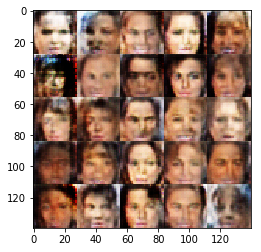

Epoch 1/1: 	 Batch 1410 -- 	 Discriminator Loss: 1.3866 	 Generator Loss: 0.6500
Epoch 1/1: 	 Batch 1420 -- 	 Discriminator Loss: 1.0806 	 Generator Loss: 0.9988
Epoch 1/1: 	 Batch 1430 -- 	 Discriminator Loss: 1.2124 	 Generator Loss: 0.7879
Epoch 1/1: 	 Batch 1440 -- 	 Discriminator Loss: 1.2323 	 Generator Loss: 0.8460
Epoch 1/1: 	 Batch 1450 -- 	 Discriminator Loss: 1.1600 	 Generator Loss: 0.8905
Epoch 1/1: 	 Batch 1460 -- 	 Discriminator Loss: 1.3732 	 Generator Loss: 0.7072
Epoch 1/1: 	 Batch 1470 -- 	 Discriminator Loss: 1.3317 	 Generator Loss: 0.8804
Epoch 1/1: 	 Batch 1480 -- 	 Discriminator Loss: 1.3240 	 Generator Loss: 0.7999
Epoch 1/1: 	 Batch 1490 -- 	 Discriminator Loss: 1.4243 	 Generator Loss: 0.6297
Epoch 1/1: 	 Batch 1500 -- 	 Discriminator Loss: 1.0257 	 Generator Loss: 1.0403


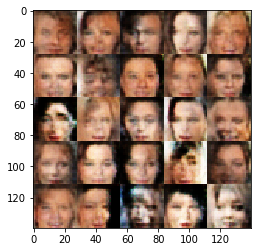

Epoch 1/1: 	 Batch 1510 -- 	 Discriminator Loss: 1.4003 	 Generator Loss: 0.7622
Epoch 1/1: 	 Batch 1520 -- 	 Discriminator Loss: 1.2813 	 Generator Loss: 0.7338
Epoch 1/1: 	 Batch 1530 -- 	 Discriminator Loss: 1.2320 	 Generator Loss: 0.8585
Epoch 1/1: 	 Batch 1540 -- 	 Discriminator Loss: 1.1577 	 Generator Loss: 0.9826
Epoch 1/1: 	 Batch 1550 -- 	 Discriminator Loss: 1.2806 	 Generator Loss: 0.7829
Epoch 1/1: 	 Batch 1560 -- 	 Discriminator Loss: 1.3593 	 Generator Loss: 0.7544
Epoch 1/1: 	 Batch 1570 -- 	 Discriminator Loss: 1.1261 	 Generator Loss: 0.8271
Epoch 1/1: 	 Batch 1580 -- 	 Discriminator Loss: 0.9157 	 Generator Loss: 1.2166
Epoch 1/1: 	 Batch 1590 -- 	 Discriminator Loss: 1.5319 	 Generator Loss: 2.0015
Epoch 1/1: 	 Batch 1600 -- 	 Discriminator Loss: 1.3467 	 Generator Loss: 0.6995


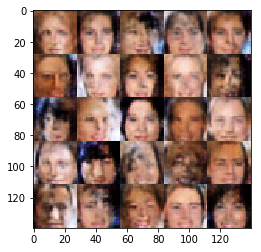

Epoch 1/1: 	 Batch 1610 -- 	 Discriminator Loss: 1.2903 	 Generator Loss: 0.8287
Epoch 1/1: 	 Batch 1620 -- 	 Discriminator Loss: 1.3491 	 Generator Loss: 0.7997
Epoch 1/1: 	 Batch 1630 -- 	 Discriminator Loss: 1.7053 	 Generator Loss: 1.9434
Epoch 1/1: 	 Batch 1640 -- 	 Discriminator Loss: 1.2340 	 Generator Loss: 0.6809
Epoch 1/1: 	 Batch 1650 -- 	 Discriminator Loss: 1.2764 	 Generator Loss: 1.2437
Epoch 1/1: 	 Batch 1660 -- 	 Discriminator Loss: 1.3138 	 Generator Loss: 0.9315
Epoch 1/1: 	 Batch 1670 -- 	 Discriminator Loss: 1.7743 	 Generator Loss: 1.8213
Epoch 1/1: 	 Batch 1680 -- 	 Discriminator Loss: 1.2560 	 Generator Loss: 0.8780
Epoch 1/1: 	 Batch 1690 -- 	 Discriminator Loss: 1.2593 	 Generator Loss: 0.8866
Epoch 1/1: 	 Batch 1700 -- 	 Discriminator Loss: 1.3164 	 Generator Loss: 0.7747


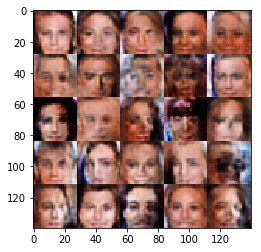

Epoch 1/1: 	 Batch 1710 -- 	 Discriminator Loss: 1.2306 	 Generator Loss: 0.8717
Epoch 1/1: 	 Batch 1720 -- 	 Discriminator Loss: 1.2259 	 Generator Loss: 0.7905
Epoch 1/1: 	 Batch 1730 -- 	 Discriminator Loss: 1.2655 	 Generator Loss: 0.8155
Epoch 1/1: 	 Batch 1740 -- 	 Discriminator Loss: 1.0377 	 Generator Loss: 1.1505
Epoch 1/1: 	 Batch 1750 -- 	 Discriminator Loss: 1.5019 	 Generator Loss: 0.4203
Epoch 1/1: 	 Batch 1760 -- 	 Discriminator Loss: 1.2328 	 Generator Loss: 1.3304
Epoch 1/1: 	 Batch 1770 -- 	 Discriminator Loss: 1.2207 	 Generator Loss: 0.8951
Epoch 1/1: 	 Batch 1780 -- 	 Discriminator Loss: 1.2445 	 Generator Loss: 0.9121
Epoch 1/1: 	 Batch 1790 -- 	 Discriminator Loss: 1.3810 	 Generator Loss: 0.8003
Epoch 1/1: 	 Batch 1800 -- 	 Discriminator Loss: 1.7883 	 Generator Loss: 0.4317


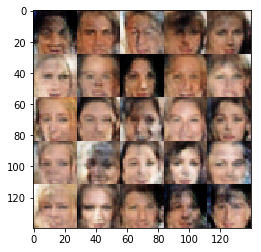

Epoch 1/1: 	 Batch 1810 -- 	 Discriminator Loss: 1.0860 	 Generator Loss: 0.9843
Epoch 1/1: 	 Batch 1820 -- 	 Discriminator Loss: 1.2101 	 Generator Loss: 0.9479
Epoch 1/1: 	 Batch 1830 -- 	 Discriminator Loss: 1.2087 	 Generator Loss: 0.7604
Epoch 1/1: 	 Batch 1840 -- 	 Discriminator Loss: 1.1597 	 Generator Loss: 0.9543
Epoch 1/1: 	 Batch 1850 -- 	 Discriminator Loss: 1.2915 	 Generator Loss: 0.9835
Epoch 1/1: 	 Batch 1860 -- 	 Discriminator Loss: 1.3336 	 Generator Loss: 0.9339
Epoch 1/1: 	 Batch 1870 -- 	 Discriminator Loss: 1.2208 	 Generator Loss: 0.9208
Epoch 1/1: 	 Batch 1880 -- 	 Discriminator Loss: 1.3596 	 Generator Loss: 0.7710
Epoch 1/1: 	 Batch 1890 -- 	 Discriminator Loss: 1.3053 	 Generator Loss: 1.0662
Epoch 1/1: 	 Batch 1900 -- 	 Discriminator Loss: 1.1812 	 Generator Loss: 0.9963


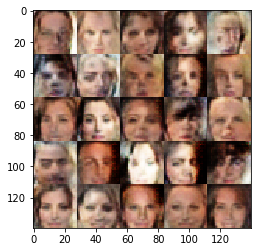

Epoch 1/1: 	 Batch 1910 -- 	 Discriminator Loss: 1.2722 	 Generator Loss: 0.8034
Epoch 1/1: 	 Batch 1920 -- 	 Discriminator Loss: 1.3146 	 Generator Loss: 0.7934
Epoch 1/1: 	 Batch 1930 -- 	 Discriminator Loss: 1.2827 	 Generator Loss: 0.8997
Epoch 1/1: 	 Batch 1940 -- 	 Discriminator Loss: 1.3756 	 Generator Loss: 0.7959
Epoch 1/1: 	 Batch 1950 -- 	 Discriminator Loss: 1.3146 	 Generator Loss: 0.8231
Epoch 1/1: 	 Batch 1960 -- 	 Discriminator Loss: 0.9259 	 Generator Loss: 1.1789
Epoch 1/1: 	 Batch 1970 -- 	 Discriminator Loss: 1.2445 	 Generator Loss: 0.9766
Epoch 1/1: 	 Batch 1980 -- 	 Discriminator Loss: 1.1474 	 Generator Loss: 0.9373
Epoch 1/1: 	 Batch 1990 -- 	 Discriminator Loss: 1.2611 	 Generator Loss: 0.8622
Epoch 1/1: 	 Batch 2000 -- 	 Discriminator Loss: 1.3408 	 Generator Loss: 0.7917


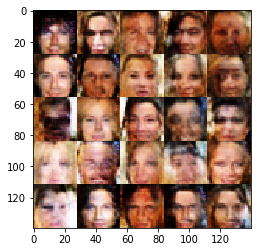

Epoch 1/1: 	 Batch 2010 -- 	 Discriminator Loss: 1.1046 	 Generator Loss: 1.0751
Epoch 1/1: 	 Batch 2020 -- 	 Discriminator Loss: 1.2740 	 Generator Loss: 0.8571
Epoch 1/1: 	 Batch 2030 -- 	 Discriminator Loss: 1.2773 	 Generator Loss: 0.8254
Epoch 1/1: 	 Batch 2040 -- 	 Discriminator Loss: 1.2527 	 Generator Loss: 0.7921
Epoch 1/1: 	 Batch 2050 -- 	 Discriminator Loss: 1.3278 	 Generator Loss: 0.7811
Epoch 1/1: 	 Batch 2060 -- 	 Discriminator Loss: 1.2774 	 Generator Loss: 0.7506
Epoch 1/1: 	 Batch 2070 -- 	 Discriminator Loss: 1.2206 	 Generator Loss: 0.8506
Epoch 1/1: 	 Batch 2080 -- 	 Discriminator Loss: 1.3210 	 Generator Loss: 0.8010
Epoch 1/1: 	 Batch 2090 -- 	 Discriminator Loss: 1.2348 	 Generator Loss: 1.0606
Epoch 1/1: 	 Batch 2100 -- 	 Discriminator Loss: 1.1143 	 Generator Loss: 0.9036


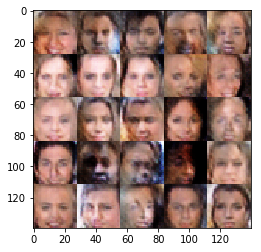

Epoch 1/1: 	 Batch 2110 -- 	 Discriminator Loss: 1.2731 	 Generator Loss: 1.1686
Epoch 1/1: 	 Batch 2120 -- 	 Discriminator Loss: 1.3575 	 Generator Loss: 0.7871
Epoch 1/1: 	 Batch 2130 -- 	 Discriminator Loss: 1.3418 	 Generator Loss: 0.7175
Epoch 1/1: 	 Batch 2140 -- 	 Discriminator Loss: 1.3178 	 Generator Loss: 0.8645
Epoch 1/1: 	 Batch 2150 -- 	 Discriminator Loss: 1.2540 	 Generator Loss: 0.8596
Epoch 1/1: 	 Batch 2160 -- 	 Discriminator Loss: 0.8764 	 Generator Loss: 1.0173
Epoch 1/1: 	 Batch 2170 -- 	 Discriminator Loss: 1.4376 	 Generator Loss: 0.6807
Epoch 1/1: 	 Batch 2180 -- 	 Discriminator Loss: 1.1988 	 Generator Loss: 0.9519
Epoch 1/1: 	 Batch 2190 -- 	 Discriminator Loss: 1.2817 	 Generator Loss: 0.8219
Epoch 1/1: 	 Batch 2200 -- 	 Discriminator Loss: 1.3388 	 Generator Loss: 0.6502


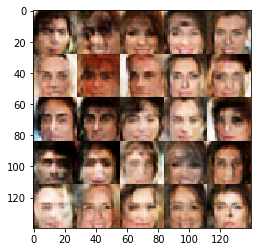

Epoch 1/1: 	 Batch 2210 -- 	 Discriminator Loss: 1.3435 	 Generator Loss: 0.6246
Epoch 1/1: 	 Batch 2220 -- 	 Discriminator Loss: 1.3464 	 Generator Loss: 0.7223
Epoch 1/1: 	 Batch 2230 -- 	 Discriminator Loss: 1.3341 	 Generator Loss: 0.7885
Epoch 1/1: 	 Batch 2240 -- 	 Discriminator Loss: 1.3059 	 Generator Loss: 0.8635
Epoch 1/1: 	 Batch 2250 -- 	 Discriminator Loss: 1.3692 	 Generator Loss: 0.7237
Epoch 1/1: 	 Batch 2260 -- 	 Discriminator Loss: 0.9748 	 Generator Loss: 1.0589
Epoch 1/1: 	 Batch 2270 -- 	 Discriminator Loss: 1.8125 	 Generator Loss: 1.8226
Epoch 1/1: 	 Batch 2280 -- 	 Discriminator Loss: 1.2891 	 Generator Loss: 0.7943
Epoch 1/1: 	 Batch 2290 -- 	 Discriminator Loss: 1.2884 	 Generator Loss: 0.9025
Epoch 1/1: 	 Batch 2300 -- 	 Discriminator Loss: 1.2538 	 Generator Loss: 0.7527


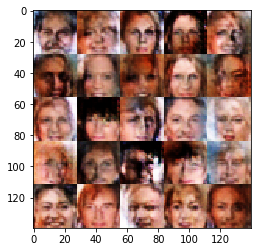

Epoch 1/1: 	 Batch 2310 -- 	 Discriminator Loss: 1.2161 	 Generator Loss: 0.8243
Epoch 1/1: 	 Batch 2320 -- 	 Discriminator Loss: 1.2871 	 Generator Loss: 0.8922
Epoch 1/1: 	 Batch 2330 -- 	 Discriminator Loss: 1.1971 	 Generator Loss: 1.0945
Epoch 1/1: 	 Batch 2340 -- 	 Discriminator Loss: 1.2900 	 Generator Loss: 0.7718
Epoch 1/1: 	 Batch 2350 -- 	 Discriminator Loss: 1.3402 	 Generator Loss: 0.7954
Epoch 1/1: 	 Batch 2360 -- 	 Discriminator Loss: 1.3650 	 Generator Loss: 0.8344
Epoch 1/1: 	 Batch 2370 -- 	 Discriminator Loss: 1.2394 	 Generator Loss: 0.8035
Epoch 1/1: 	 Batch 2380 -- 	 Discriminator Loss: 1.3056 	 Generator Loss: 0.8478
Epoch 1/1: 	 Batch 2390 -- 	 Discriminator Loss: 1.2404 	 Generator Loss: 0.7887
Epoch 1/1: 	 Batch 2400 -- 	 Discriminator Loss: 1.2743 	 Generator Loss: 0.8198


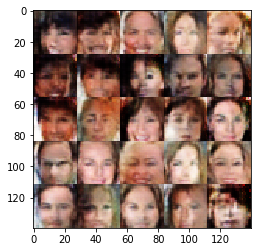

Epoch 1/1: 	 Batch 2410 -- 	 Discriminator Loss: 1.2770 	 Generator Loss: 0.8752
Epoch 1/1: 	 Batch 2420 -- 	 Discriminator Loss: 1.1953 	 Generator Loss: 0.8847
Epoch 1/1: 	 Batch 2430 -- 	 Discriminator Loss: 1.0210 	 Generator Loss: 0.9434
Epoch 1/1: 	 Batch 2440 -- 	 Discriminator Loss: 1.3309 	 Generator Loss: 1.0555
Epoch 1/1: 	 Batch 2450 -- 	 Discriminator Loss: 1.2707 	 Generator Loss: 0.7301
Epoch 1/1: 	 Batch 2460 -- 	 Discriminator Loss: 1.2427 	 Generator Loss: 0.9000
Epoch 1/1: 	 Batch 2470 -- 	 Discriminator Loss: 1.2645 	 Generator Loss: 0.9381
Epoch 1/1: 	 Batch 2480 -- 	 Discriminator Loss: 1.2665 	 Generator Loss: 0.8334
Epoch 1/1: 	 Batch 2490 -- 	 Discriminator Loss: 1.3273 	 Generator Loss: 0.8264
Epoch 1/1: 	 Batch 2500 -- 	 Discriminator Loss: 1.2132 	 Generator Loss: 0.9915


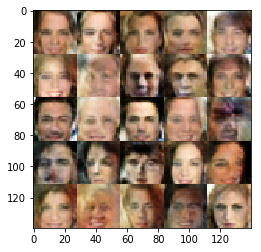

Epoch 1/1: 	 Batch 2510 -- 	 Discriminator Loss: 1.3143 	 Generator Loss: 0.7271
Epoch 1/1: 	 Batch 2520 -- 	 Discriminator Loss: 1.1876 	 Generator Loss: 0.8031
Epoch 1/1: 	 Batch 2530 -- 	 Discriminator Loss: 1.2744 	 Generator Loss: 0.6839
Epoch 1/1: 	 Batch 2540 -- 	 Discriminator Loss: 1.3067 	 Generator Loss: 0.7744
Epoch 1/1: 	 Batch 2550 -- 	 Discriminator Loss: 1.1958 	 Generator Loss: 0.8374
Epoch 1/1: 	 Batch 2560 -- 	 Discriminator Loss: 1.1862 	 Generator Loss: 0.9668
Epoch 1/1: 	 Batch 2570 -- 	 Discriminator Loss: 1.3555 	 Generator Loss: 0.7915
Epoch 1/1: 	 Batch 2580 -- 	 Discriminator Loss: 1.3025 	 Generator Loss: 0.7243
Epoch 1/1: 	 Batch 2590 -- 	 Discriminator Loss: 1.1830 	 Generator Loss: 1.0504
Epoch 1/1: 	 Batch 2600 -- 	 Discriminator Loss: 1.2741 	 Generator Loss: 0.8191


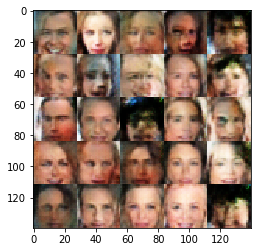

Epoch 1/1: 	 Batch 2610 -- 	 Discriminator Loss: 1.2805 	 Generator Loss: 0.7732
Epoch 1/1: 	 Batch 2620 -- 	 Discriminator Loss: 1.3163 	 Generator Loss: 0.7752
Epoch 1/1: 	 Batch 2630 -- 	 Discriminator Loss: 1.2290 	 Generator Loss: 0.8889
Epoch 1/1: 	 Batch 2640 -- 	 Discriminator Loss: 1.8351 	 Generator Loss: 2.2050
Epoch 1/1: 	 Batch 2650 -- 	 Discriminator Loss: 1.4154 	 Generator Loss: 0.7002
Epoch 1/1: 	 Batch 2660 -- 	 Discriminator Loss: 1.2666 	 Generator Loss: 0.7630
Epoch 1/1: 	 Batch 2670 -- 	 Discriminator Loss: 1.1388 	 Generator Loss: 0.8931
Epoch 1/1: 	 Batch 2680 -- 	 Discriminator Loss: 1.2589 	 Generator Loss: 0.7875
Epoch 1/1: 	 Batch 2690 -- 	 Discriminator Loss: 1.3324 	 Generator Loss: 0.7912
Epoch 1/1: 	 Batch 2700 -- 	 Discriminator Loss: 1.2241 	 Generator Loss: 0.8756


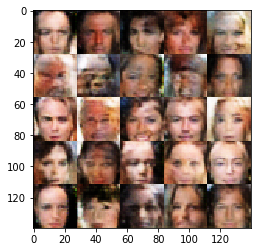

Epoch 1/1: 	 Batch 2710 -- 	 Discriminator Loss: 1.2367 	 Generator Loss: 0.8077
Epoch 1/1: 	 Batch 2720 -- 	 Discriminator Loss: 1.2314 	 Generator Loss: 0.7644
Epoch 1/1: 	 Batch 2730 -- 	 Discriminator Loss: 1.1777 	 Generator Loss: 0.9822
Epoch 1/1: 	 Batch 2740 -- 	 Discriminator Loss: 1.2118 	 Generator Loss: 0.8783
Epoch 1/1: 	 Batch 2750 -- 	 Discriminator Loss: 1.2369 	 Generator Loss: 0.9305
Epoch 1/1: 	 Batch 2760 -- 	 Discriminator Loss: 1.3908 	 Generator Loss: 0.8820
Epoch 1/1: 	 Batch 2770 -- 	 Discriminator Loss: 1.3179 	 Generator Loss: 0.7794
Epoch 1/1: 	 Batch 2780 -- 	 Discriminator Loss: 1.2369 	 Generator Loss: 0.8170
Epoch 1/1: 	 Batch 2790 -- 	 Discriminator Loss: 1.3353 	 Generator Loss: 0.8097
Epoch 1/1: 	 Batch 2800 -- 	 Discriminator Loss: 1.2783 	 Generator Loss: 0.8715


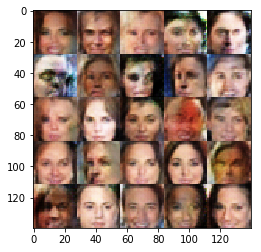

Epoch 1/1: 	 Batch 2810 -- 	 Discriminator Loss: 1.2242 	 Generator Loss: 0.9865
Epoch 1/1: 	 Batch 2820 -- 	 Discriminator Loss: 1.3395 	 Generator Loss: 0.7062
Epoch 1/1: 	 Batch 2830 -- 	 Discriminator Loss: 1.1129 	 Generator Loss: 0.9058
Epoch 1/1: 	 Batch 2840 -- 	 Discriminator Loss: 1.2491 	 Generator Loss: 0.7385
Epoch 1/1: 	 Batch 2850 -- 	 Discriminator Loss: 1.3566 	 Generator Loss: 1.5848
Epoch 1/1: 	 Batch 2860 -- 	 Discriminator Loss: 1.3605 	 Generator Loss: 0.6494
Epoch 1/1: 	 Batch 2870 -- 	 Discriminator Loss: 1.2423 	 Generator Loss: 0.9382
Epoch 1/1: 	 Batch 2880 -- 	 Discriminator Loss: 1.3452 	 Generator Loss: 0.7484
Epoch 1/1: 	 Batch 2890 -- 	 Discriminator Loss: 1.3255 	 Generator Loss: 0.7827
Epoch 1/1: 	 Batch 2900 -- 	 Discriminator Loss: 1.2782 	 Generator Loss: 0.7911


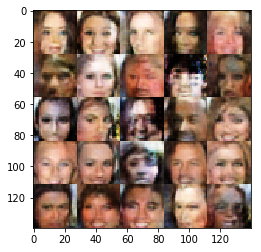

Epoch 1/1: 	 Batch 2910 -- 	 Discriminator Loss: 1.0966 	 Generator Loss: 0.8668
Epoch 1/1: 	 Batch 2920 -- 	 Discriminator Loss: 1.3298 	 Generator Loss: 0.6987
Epoch 1/1: 	 Batch 2930 -- 	 Discriminator Loss: 1.1115 	 Generator Loss: 1.0207
Epoch 1/1: 	 Batch 2940 -- 	 Discriminator Loss: 1.2495 	 Generator Loss: 0.8436
Epoch 1/1: 	 Batch 2950 -- 	 Discriminator Loss: 1.3717 	 Generator Loss: 0.7665
Epoch 1/1: 	 Batch 2960 -- 	 Discriminator Loss: 1.3173 	 Generator Loss: 0.6815
Epoch 1/1: 	 Batch 2970 -- 	 Discriminator Loss: 1.2614 	 Generator Loss: 0.7401
Epoch 1/1: 	 Batch 2980 -- 	 Discriminator Loss: 1.1976 	 Generator Loss: 0.9939
Epoch 1/1: 	 Batch 2990 -- 	 Discriminator Loss: 1.1934 	 Generator Loss: 0.9216
Epoch 1/1: 	 Batch 3000 -- 	 Discriminator Loss: 1.2686 	 Generator Loss: 0.7776


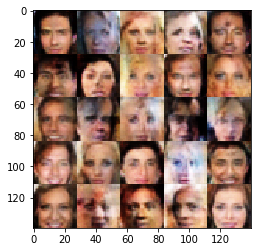

Epoch 1/1: 	 Batch 3010 -- 	 Discriminator Loss: 1.2400 	 Generator Loss: 0.7854
Epoch 1/1: 	 Batch 3020 -- 	 Discriminator Loss: 1.2479 	 Generator Loss: 0.8450
Epoch 1/1: 	 Batch 3030 -- 	 Discriminator Loss: 1.3409 	 Generator Loss: 0.7525
Epoch 1/1: 	 Batch 3040 -- 	 Discriminator Loss: 1.2244 	 Generator Loss: 0.7716
Epoch 1/1: 	 Batch 3050 -- 	 Discriminator Loss: 1.1769 	 Generator Loss: 0.8047
Epoch 1/1: 	 Batch 3060 -- 	 Discriminator Loss: 1.3726 	 Generator Loss: 0.7492
Epoch 1/1: 	 Batch 3070 -- 	 Discriminator Loss: 1.2599 	 Generator Loss: 0.7680
Epoch 1/1: 	 Batch 3080 -- 	 Discriminator Loss: 1.3394 	 Generator Loss: 0.7734
Epoch 1/1: 	 Batch 3090 -- 	 Discriminator Loss: 1.3012 	 Generator Loss: 0.6884
Epoch 1/1: 	 Batch 3100 -- 	 Discriminator Loss: 1.2118 	 Generator Loss: 0.8765


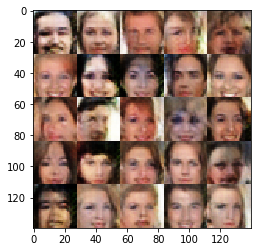

Epoch 1/1: 	 Batch 3110 -- 	 Discriminator Loss: 1.3117 	 Generator Loss: 0.7959
Epoch 1/1: 	 Batch 3120 -- 	 Discriminator Loss: 1.0869 	 Generator Loss: 1.0054
Epoch 1/1: 	 Batch 3130 -- 	 Discriminator Loss: 0.8631 	 Generator Loss: 1.4633
Epoch 1/1: 	 Batch 3140 -- 	 Discriminator Loss: 1.2414 	 Generator Loss: 1.0559
Epoch 1/1: 	 Batch 3150 -- 	 Discriminator Loss: 1.2159 	 Generator Loss: 0.8456
Epoch 1/1: 	 Batch 3160 -- 	 Discriminator Loss: 1.2831 	 Generator Loss: 0.8778
Epoch 1/1: 	 Batch 3170 -- 	 Discriminator Loss: 1.2353 	 Generator Loss: 0.7656
Epoch 1/1: 	 Batch 3180 -- 	 Discriminator Loss: 1.2578 	 Generator Loss: 0.7696
Epoch 1/1: 	 Batch 3190 -- 	 Discriminator Loss: 1.3111 	 Generator Loss: 0.8021
Epoch 1/1: 	 Batch 3200 -- 	 Discriminator Loss: 1.2827 	 Generator Loss: 0.8608


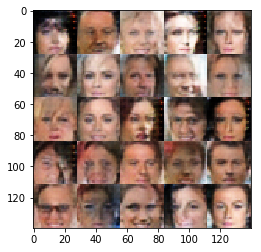

Epoch 1/1: 	 Batch 3210 -- 	 Discriminator Loss: 1.1109 	 Generator Loss: 0.8461
Epoch 1/1: 	 Batch 3220 -- 	 Discriminator Loss: 1.3102 	 Generator Loss: 0.8198
Epoch 1/1: 	 Batch 3230 -- 	 Discriminator Loss: 1.1174 	 Generator Loss: 0.9213
Epoch 1/1: 	 Batch 3240 -- 	 Discriminator Loss: 1.2505 	 Generator Loss: 1.1390
Epoch 1/1: 	 Batch 3250 -- 	 Discriminator Loss: 1.3016 	 Generator Loss: 0.8997
Epoch 1/1: 	 Batch 3260 -- 	 Discriminator Loss: 1.1796 	 Generator Loss: 0.6991
Epoch 1/1: 	 Batch 3270 -- 	 Discriminator Loss: 3.0258 	 Generator Loss: 6.6305
Epoch 1/1: 	 Batch 3280 -- 	 Discriminator Loss: 1.2423 	 Generator Loss: 0.7739
Epoch 1/1: 	 Batch 3290 -- 	 Discriminator Loss: 1.2603 	 Generator Loss: 0.7725
Epoch 1/1: 	 Batch 3300 -- 	 Discriminator Loss: 1.3407 	 Generator Loss: 0.8144


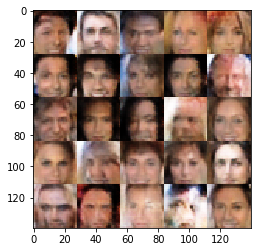

Epoch 1/1: 	 Batch 3310 -- 	 Discriminator Loss: 1.3789 	 Generator Loss: 0.9175
Epoch 1/1: 	 Batch 3320 -- 	 Discriminator Loss: 1.2352 	 Generator Loss: 0.7869
Epoch 1/1: 	 Batch 3330 -- 	 Discriminator Loss: 1.2058 	 Generator Loss: 0.7893
Epoch 1/1: 	 Batch 3340 -- 	 Discriminator Loss: 1.1971 	 Generator Loss: 0.8537
Epoch 1/1: 	 Batch 3350 -- 	 Discriminator Loss: 1.2943 	 Generator Loss: 0.7874
Epoch 1/1: 	 Batch 3360 -- 	 Discriminator Loss: 1.1607 	 Generator Loss: 0.8898
Epoch 1/1: 	 Batch 3370 -- 	 Discriminator Loss: 1.2900 	 Generator Loss: 0.6862
Epoch 1/1: 	 Batch 3380 -- 	 Discriminator Loss: 1.2391 	 Generator Loss: 0.7901
Epoch 1/1: 	 Batch 3390 -- 	 Discriminator Loss: 1.2945 	 Generator Loss: 0.7539
Epoch 1/1: 	 Batch 3400 -- 	 Discriminator Loss: 1.2467 	 Generator Loss: 0.9223


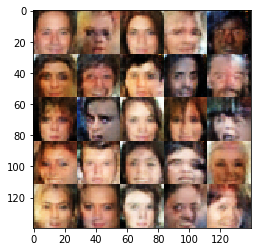

Epoch 1/1: 	 Batch 3410 -- 	 Discriminator Loss: 1.3094 	 Generator Loss: 0.8830
Epoch 1/1: 	 Batch 3420 -- 	 Discriminator Loss: 1.2436 	 Generator Loss: 0.8294
Epoch 1/1: 	 Batch 3430 -- 	 Discriminator Loss: 1.3144 	 Generator Loss: 0.7560
Epoch 1/1: 	 Batch 3440 -- 	 Discriminator Loss: 1.2719 	 Generator Loss: 0.8348
Epoch 1/1: 	 Batch 3450 -- 	 Discriminator Loss: 1.2316 	 Generator Loss: 0.9007
Epoch 1/1: 	 Batch 3460 -- 	 Discriminator Loss: 1.2604 	 Generator Loss: 0.8165
Epoch 1/1: 	 Batch 3470 -- 	 Discriminator Loss: 1.3937 	 Generator Loss: 0.7593
Epoch 1/1: 	 Batch 3480 -- 	 Discriminator Loss: 1.1592 	 Generator Loss: 0.9435
Epoch 1/1: 	 Batch 3490 -- 	 Discriminator Loss: 1.2385 	 Generator Loss: 0.8979
Epoch 1/1: 	 Batch 3500 -- 	 Discriminator Loss: 1.2299 	 Generator Loss: 0.7897


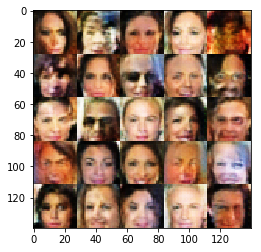

Epoch 1/1: 	 Batch 3510 -- 	 Discriminator Loss: 1.2874 	 Generator Loss: 0.7489
Epoch 1/1: 	 Batch 3520 -- 	 Discriminator Loss: 1.5196 	 Generator Loss: 0.6726
Epoch 1/1: 	 Batch 3530 -- 	 Discriminator Loss: 1.2258 	 Generator Loss: 0.8587
Epoch 1/1: 	 Batch 3540 -- 	 Discriminator Loss: 1.3790 	 Generator Loss: 0.7141
Epoch 1/1: 	 Batch 3550 -- 	 Discriminator Loss: 1.4373 	 Generator Loss: 0.6930
Epoch 1/1: 	 Batch 3560 -- 	 Discriminator Loss: 1.3098 	 Generator Loss: 0.6977
Epoch 1/1: 	 Batch 3570 -- 	 Discriminator Loss: 1.2924 	 Generator Loss: 0.7652
Epoch 1/1: 	 Batch 3580 -- 	 Discriminator Loss: 1.2839 	 Generator Loss: 0.8920
Epoch 1/1: 	 Batch 3590 -- 	 Discriminator Loss: 1.3624 	 Generator Loss: 0.7140
Epoch 1/1: 	 Batch 3600 -- 	 Discriminator Loss: 1.3358 	 Generator Loss: 0.7670


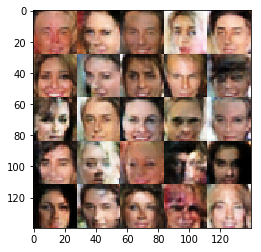

Epoch 1/1: 	 Batch 3610 -- 	 Discriminator Loss: 1.3156 	 Generator Loss: 0.7332
Epoch 1/1: 	 Batch 3620 -- 	 Discriminator Loss: 1.3329 	 Generator Loss: 0.8026
Epoch 1/1: 	 Batch 3630 -- 	 Discriminator Loss: 1.2479 	 Generator Loss: 0.8364
Epoch 1/1: 	 Batch 3640 -- 	 Discriminator Loss: 1.1978 	 Generator Loss: 0.8454
Epoch 1/1: 	 Batch 3650 -- 	 Discriminator Loss: 1.2745 	 Generator Loss: 0.7283
Epoch 1/1: 	 Batch 3660 -- 	 Discriminator Loss: 1.3592 	 Generator Loss: 0.7436
Epoch 1/1: 	 Batch 3670 -- 	 Discriminator Loss: 1.2389 	 Generator Loss: 0.8617
Epoch 1/1: 	 Batch 3680 -- 	 Discriminator Loss: 1.2688 	 Generator Loss: 0.8585
Epoch 1/1: 	 Batch 3690 -- 	 Discriminator Loss: 1.2075 	 Generator Loss: 0.8787
Epoch 1/1: 	 Batch 3700 -- 	 Discriminator Loss: 1.1795 	 Generator Loss: 0.7916


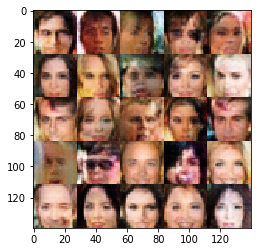

Epoch 1/1: 	 Batch 3710 -- 	 Discriminator Loss: 1.3429 	 Generator Loss: 0.7126
Epoch 1/1: 	 Batch 3720 -- 	 Discriminator Loss: 1.3663 	 Generator Loss: 0.6780
Epoch 1/1: 	 Batch 3730 -- 	 Discriminator Loss: 1.2940 	 Generator Loss: 0.9625
Epoch 1/1: 	 Batch 3740 -- 	 Discriminator Loss: 1.3474 	 Generator Loss: 0.6985
Epoch 1/1: 	 Batch 3750 -- 	 Discriminator Loss: 1.2120 	 Generator Loss: 0.8059
Epoch 1/1: 	 Batch 3760 -- 	 Discriminator Loss: 1.3456 	 Generator Loss: 0.8315
Epoch 1/1: 	 Batch 3770 -- 	 Discriminator Loss: 1.3155 	 Generator Loss: 0.7948
Epoch 1/1: 	 Batch 3780 -- 	 Discriminator Loss: 1.2851 	 Generator Loss: 0.7906
Epoch 1/1: 	 Batch 3790 -- 	 Discriminator Loss: 1.1952 	 Generator Loss: 0.8138
Epoch 1/1: 	 Batch 3800 -- 	 Discriminator Loss: 1.3746 	 Generator Loss: 0.6441


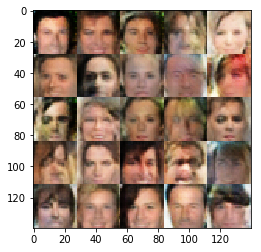

Epoch 1/1: 	 Batch 3810 -- 	 Discriminator Loss: 1.3411 	 Generator Loss: 0.7033
Epoch 1/1: 	 Batch 3820 -- 	 Discriminator Loss: 1.2740 	 Generator Loss: 0.8185
Epoch 1/1: 	 Batch 3830 -- 	 Discriminator Loss: 1.3837 	 Generator Loss: 0.7817
Epoch 1/1: 	 Batch 3840 -- 	 Discriminator Loss: 1.2824 	 Generator Loss: 0.8406
Epoch 1/1: 	 Batch 3850 -- 	 Discriminator Loss: 1.3110 	 Generator Loss: 0.7181
Epoch 1/1: 	 Batch 3860 -- 	 Discriminator Loss: 1.4643 	 Generator Loss: 0.6302
Epoch 1/1: 	 Batch 3870 -- 	 Discriminator Loss: 1.2167 	 Generator Loss: 0.8940
Epoch 1/1: 	 Batch 3880 -- 	 Discriminator Loss: 1.3637 	 Generator Loss: 0.7998
Epoch 1/1: 	 Batch 3890 -- 	 Discriminator Loss: 1.2107 	 Generator Loss: 0.8318
Epoch 1/1: 	 Batch 3900 -- 	 Discriminator Loss: 1.2399 	 Generator Loss: 0.7572


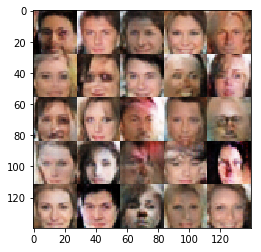

Epoch 1/1: 	 Batch 3910 -- 	 Discriminator Loss: 1.3783 	 Generator Loss: 0.8508
Epoch 1/1: 	 Batch 3920 -- 	 Discriminator Loss: 1.4090 	 Generator Loss: 0.6967
Epoch 1/1: 	 Batch 3930 -- 	 Discriminator Loss: 1.2518 	 Generator Loss: 0.7923
Epoch 1/1: 	 Batch 3940 -- 	 Discriminator Loss: 1.2183 	 Generator Loss: 0.8582
Epoch 1/1: 	 Batch 3950 -- 	 Discriminator Loss: 1.3085 	 Generator Loss: 0.7967
Epoch 1/1: 	 Batch 3960 -- 	 Discriminator Loss: 1.2359 	 Generator Loss: 0.8524
Epoch 1/1: 	 Batch 3970 -- 	 Discriminator Loss: 1.2803 	 Generator Loss: 0.7662
Epoch 1/1: 	 Batch 3980 -- 	 Discriminator Loss: 1.2084 	 Generator Loss: 0.8178
Epoch 1/1: 	 Batch 3990 -- 	 Discriminator Loss: 1.3093 	 Generator Loss: 0.7479
Epoch 1/1: 	 Batch 4000 -- 	 Discriminator Loss: 1.1761 	 Generator Loss: 0.8474


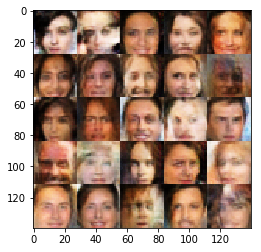

Epoch 1/1: 	 Batch 4010 -- 	 Discriminator Loss: 1.2702 	 Generator Loss: 0.8255
Epoch 1/1: 	 Batch 4020 -- 	 Discriminator Loss: 1.1839 	 Generator Loss: 0.8838
Epoch 1/1: 	 Batch 4030 -- 	 Discriminator Loss: 1.3233 	 Generator Loss: 0.6899
Epoch 1/1: 	 Batch 4040 -- 	 Discriminator Loss: 1.2547 	 Generator Loss: 0.8577
Epoch 1/1: 	 Batch 4050 -- 	 Discriminator Loss: 1.3448 	 Generator Loss: 0.7990
Epoch 1/1: 	 Batch 4060 -- 	 Discriminator Loss: 1.2767 	 Generator Loss: 0.7192
Epoch 1/1: 	 Batch 4070 -- 	 Discriminator Loss: 1.2699 	 Generator Loss: 0.8237
Epoch 1/1: 	 Batch 4080 -- 	 Discriminator Loss: 1.1792 	 Generator Loss: 0.8661
Epoch 1/1: 	 Batch 4090 -- 	 Discriminator Loss: 1.2908 	 Generator Loss: 0.9447
Epoch 1/1: 	 Batch 4100 -- 	 Discriminator Loss: 1.3021 	 Generator Loss: 0.7653


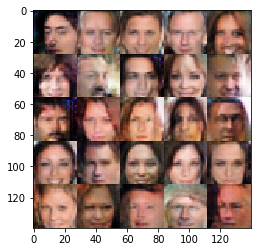

Epoch 1/1: 	 Batch 4110 -- 	 Discriminator Loss: 1.2990 	 Generator Loss: 0.7669
Epoch 1/1: 	 Batch 4120 -- 	 Discriminator Loss: 1.1710 	 Generator Loss: 0.8690
Epoch 1/1: 	 Batch 4130 -- 	 Discriminator Loss: 1.3091 	 Generator Loss: 0.7568
Epoch 1/1: 	 Batch 4140 -- 	 Discriminator Loss: 1.3293 	 Generator Loss: 0.7221
Epoch 1/1: 	 Batch 4150 -- 	 Discriminator Loss: 1.2230 	 Generator Loss: 0.7891
Epoch 1/1: 	 Batch 4160 -- 	 Discriminator Loss: 1.1921 	 Generator Loss: 0.8570
Epoch 1/1: 	 Batch 4170 -- 	 Discriminator Loss: 1.3016 	 Generator Loss: 0.7637
Epoch 1/1: 	 Batch 4180 -- 	 Discriminator Loss: 1.3587 	 Generator Loss: 0.7316
Epoch 1/1: 	 Batch 4190 -- 	 Discriminator Loss: 1.2630 	 Generator Loss: 0.7813
Epoch 1/1: 	 Batch 4200 -- 	 Discriminator Loss: 1.1926 	 Generator Loss: 0.8316


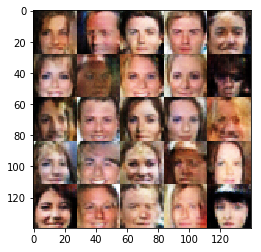

Epoch 1/1: 	 Batch 4210 -- 	 Discriminator Loss: 1.3326 	 Generator Loss: 0.7571
Epoch 1/1: 	 Batch 4220 -- 	 Discriminator Loss: 1.2867 	 Generator Loss: 0.7462
Epoch 1/1: 	 Batch 4230 -- 	 Discriminator Loss: 1.2880 	 Generator Loss: 0.7929
Epoch 1/1: 	 Batch 4240 -- 	 Discriminator Loss: 1.2241 	 Generator Loss: 0.7932
Epoch 1/1: 	 Batch 4250 -- 	 Discriminator Loss: 1.2911 	 Generator Loss: 0.7617
Epoch 1/1: 	 Batch 4260 -- 	 Discriminator Loss: 1.3010 	 Generator Loss: 0.7814
Epoch 1/1: 	 Batch 4270 -- 	 Discriminator Loss: 1.2477 	 Generator Loss: 0.7430
Epoch 1/1: 	 Batch 4280 -- 	 Discriminator Loss: 1.2290 	 Generator Loss: 0.7584
Epoch 1/1: 	 Batch 4290 -- 	 Discriminator Loss: 0.9794 	 Generator Loss: 1.0094
Epoch 1/1: 	 Batch 4300 -- 	 Discriminator Loss: 1.2743 	 Generator Loss: 0.7605


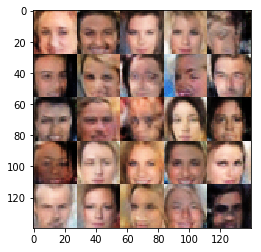

Epoch 1/1: 	 Batch 4310 -- 	 Discriminator Loss: 1.4041 	 Generator Loss: 0.8045
Epoch 1/1: 	 Batch 4320 -- 	 Discriminator Loss: 1.3011 	 Generator Loss: 0.8113
Epoch 1/1: 	 Batch 4330 -- 	 Discriminator Loss: 1.1830 	 Generator Loss: 0.9084
Epoch 1/1: 	 Batch 4340 -- 	 Discriminator Loss: 1.3795 	 Generator Loss: 0.6864
Epoch 1/1: 	 Batch 4350 -- 	 Discriminator Loss: 1.1949 	 Generator Loss: 0.8025
Epoch 1/1: 	 Batch 4360 -- 	 Discriminator Loss: 1.2782 	 Generator Loss: 0.8093
Epoch 1/1: 	 Batch 4370 -- 	 Discriminator Loss: 1.2510 	 Generator Loss: 0.8283
Epoch 1/1: 	 Batch 4380 -- 	 Discriminator Loss: 1.2910 	 Generator Loss: 0.8341
Epoch 1/1: 	 Batch 4390 -- 	 Discriminator Loss: 1.2237 	 Generator Loss: 0.8016
Epoch 1/1: 	 Batch 4400 -- 	 Discriminator Loss: 1.3533 	 Generator Loss: 0.7574


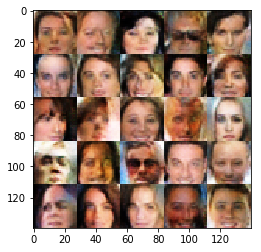

Epoch 1/1: 	 Batch 4410 -- 	 Discriminator Loss: 1.2426 	 Generator Loss: 0.8137
Epoch 1/1: 	 Batch 4420 -- 	 Discriminator Loss: 1.2786 	 Generator Loss: 0.7504
Epoch 1/1: 	 Batch 4430 -- 	 Discriminator Loss: 1.2859 	 Generator Loss: 0.7155
Epoch 1/1: 	 Batch 4440 -- 	 Discriminator Loss: 1.2968 	 Generator Loss: 1.0032
Epoch 1/1: 	 Batch 4450 -- 	 Discriminator Loss: 1.3066 	 Generator Loss: 0.7114
Epoch 1/1: 	 Batch 4460 -- 	 Discriminator Loss: 1.3137 	 Generator Loss: 0.7191
Epoch 1/1: 	 Batch 4470 -- 	 Discriminator Loss: 1.1869 	 Generator Loss: 0.8523
Epoch 1/1: 	 Batch 4480 -- 	 Discriminator Loss: 1.2704 	 Generator Loss: 0.7719
Epoch 1/1: 	 Batch 4490 -- 	 Discriminator Loss: 1.3215 	 Generator Loss: 0.8076
Epoch 1/1: 	 Batch 4500 -- 	 Discriminator Loss: 1.3422 	 Generator Loss: 0.7006


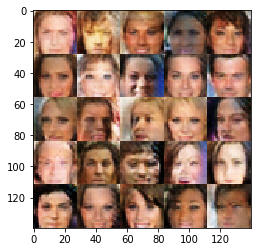

Epoch 1/1: 	 Batch 4510 -- 	 Discriminator Loss: 1.3056 	 Generator Loss: 0.7685
Epoch 1/1: 	 Batch 4520 -- 	 Discriminator Loss: 1.1810 	 Generator Loss: 0.8356
Epoch 1/1: 	 Batch 4530 -- 	 Discriminator Loss: 1.2516 	 Generator Loss: 0.8102
Epoch 1/1: 	 Batch 4540 -- 	 Discriminator Loss: 1.1727 	 Generator Loss: 0.8066
Epoch 1/1: 	 Batch 4550 -- 	 Discriminator Loss: 1.3343 	 Generator Loss: 0.7193
Epoch 1/1: 	 Batch 4560 -- 	 Discriminator Loss: 1.1828 	 Generator Loss: 0.9200
Epoch 1/1: 	 Batch 4570 -- 	 Discriminator Loss: 1.2009 	 Generator Loss: 0.8415
Epoch 1/1: 	 Batch 4580 -- 	 Discriminator Loss: 1.2662 	 Generator Loss: 0.8504
Epoch 1/1: 	 Batch 4590 -- 	 Discriminator Loss: 1.3260 	 Generator Loss: 0.7242
Epoch 1/1: 	 Batch 4600 -- 	 Discriminator Loss: 1.2278 	 Generator Loss: 0.8517


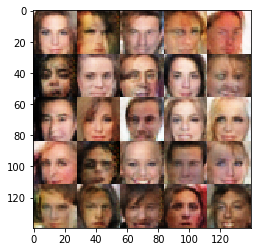

Epoch 1/1: 	 Batch 4610 -- 	 Discriminator Loss: 1.3508 	 Generator Loss: 0.9134
Epoch 1/1: 	 Batch 4620 -- 	 Discriminator Loss: 1.2862 	 Generator Loss: 0.7625
Epoch 1/1: 	 Batch 4630 -- 	 Discriminator Loss: 1.3078 	 Generator Loss: 0.6980
Epoch 1/1: 	 Batch 4640 -- 	 Discriminator Loss: 1.2870 	 Generator Loss: 0.7592
Epoch 1/1: 	 Batch 4650 -- 	 Discriminator Loss: 1.2747 	 Generator Loss: 0.8126
Epoch 1/1: 	 Batch 4660 -- 	 Discriminator Loss: 1.2992 	 Generator Loss: 0.7578
Epoch 1/1: 	 Batch 4670 -- 	 Discriminator Loss: 1.2347 	 Generator Loss: 0.9026
Epoch 1/1: 	 Batch 4680 -- 	 Discriminator Loss: 1.2174 	 Generator Loss: 0.8834
Epoch 1/1: 	 Batch 4690 -- 	 Discriminator Loss: 1.1058 	 Generator Loss: 0.8648
Epoch 1/1: 	 Batch 4700 -- 	 Discriminator Loss: 1.1936 	 Generator Loss: 0.8387


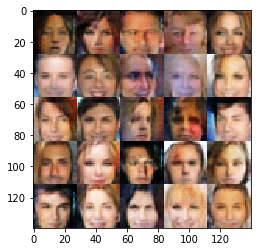

Epoch 1/1: 	 Batch 4710 -- 	 Discriminator Loss: 1.2705 	 Generator Loss: 0.8243
Epoch 1/1: 	 Batch 4720 -- 	 Discriminator Loss: 1.2403 	 Generator Loss: 0.7030
Epoch 1/1: 	 Batch 4730 -- 	 Discriminator Loss: 1.3206 	 Generator Loss: 0.8164
Epoch 1/1: 	 Batch 4740 -- 	 Discriminator Loss: 1.2041 	 Generator Loss: 0.8975
Epoch 1/1: 	 Batch 4750 -- 	 Discriminator Loss: 1.4115 	 Generator Loss: 0.7372
Epoch 1/1: 	 Batch 4760 -- 	 Discriminator Loss: 1.2404 	 Generator Loss: 0.8187
Epoch 1/1: 	 Batch 4770 -- 	 Discriminator Loss: 1.3168 	 Generator Loss: 0.7732
Epoch 1/1: 	 Batch 4780 -- 	 Discriminator Loss: 1.2937 	 Generator Loss: 0.7191
Epoch 1/1: 	 Batch 4790 -- 	 Discriminator Loss: 1.2383 	 Generator Loss: 0.8259
Epoch 1/1: 	 Batch 4800 -- 	 Discriminator Loss: 1.3398 	 Generator Loss: 0.7258


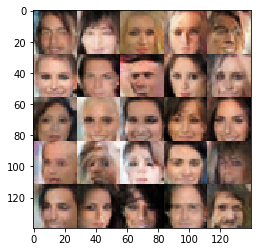

Epoch 1/1: 	 Batch 4810 -- 	 Discriminator Loss: 1.2592 	 Generator Loss: 0.8521
Epoch 1/1: 	 Batch 4820 -- 	 Discriminator Loss: 1.0601 	 Generator Loss: 0.9727
Epoch 1/1: 	 Batch 4830 -- 	 Discriminator Loss: 1.2393 	 Generator Loss: 0.6698
Epoch 1/1: 	 Batch 4840 -- 	 Discriminator Loss: 1.3571 	 Generator Loss: 0.8526
Epoch 1/1: 	 Batch 4850 -- 	 Discriminator Loss: 1.2962 	 Generator Loss: 0.7757
Epoch 1/1: 	 Batch 4860 -- 	 Discriminator Loss: 1.0609 	 Generator Loss: 1.0535
Epoch 1/1: 	 Batch 4870 -- 	 Discriminator Loss: 1.5352 	 Generator Loss: 0.4435
Epoch 1/1: 	 Batch 4880 -- 	 Discriminator Loss: 0.7686 	 Generator Loss: 2.6517
Epoch 1/1: 	 Batch 4890 -- 	 Discriminator Loss: 1.1443 	 Generator Loss: 0.8453
Epoch 1/1: 	 Batch 4900 -- 	 Discriminator Loss: 1.2360 	 Generator Loss: 0.8683


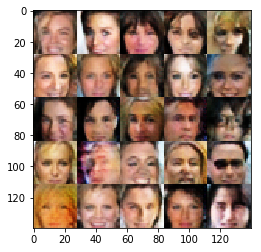

Epoch 1/1: 	 Batch 4920 -- 	 Discriminator Loss: 1.1741 	 Generator Loss: 0.8225
Epoch 1/1: 	 Batch 4930 -- 	 Discriminator Loss: 1.2596 	 Generator Loss: 0.8565
Epoch 1/1: 	 Batch 4940 -- 	 Discriminator Loss: 1.2448 	 Generator Loss: 0.8440
Epoch 1/1: 	 Batch 4950 -- 	 Discriminator Loss: 1.3207 	 Generator Loss: 0.7269
Epoch 1/1: 	 Batch 4960 -- 	 Discriminator Loss: 1.2153 	 Generator Loss: 0.9042
Epoch 1/1: 	 Batch 4970 -- 	 Discriminator Loss: 1.1548 	 Generator Loss: 0.9494
Epoch 1/1: 	 Batch 4980 -- 	 Discriminator Loss: 1.1947 	 Generator Loss: 0.9498
Epoch 1/1: 	 Batch 4990 -- 	 Discriminator Loss: 1.1495 	 Generator Loss: 0.9252
Epoch 1/1: 	 Batch 5000 -- 	 Discriminator Loss: 1.0817 	 Generator Loss: 1.0112


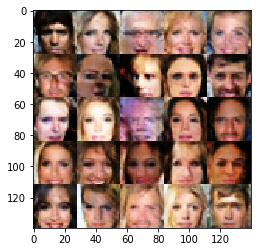

Epoch 1/1: 	 Batch 5010 -- 	 Discriminator Loss: 1.2774 	 Generator Loss: 0.8251
Epoch 1/1: 	 Batch 5020 -- 	 Discriminator Loss: 1.1642 	 Generator Loss: 1.0183
Epoch 1/1: 	 Batch 5030 -- 	 Discriminator Loss: 1.2569 	 Generator Loss: 0.8101
Epoch 1/1: 	 Batch 5040 -- 	 Discriminator Loss: 1.2184 	 Generator Loss: 0.8233
Epoch 1/1: 	 Batch 5050 -- 	 Discriminator Loss: 1.2168 	 Generator Loss: 0.8117
Epoch 1/1: 	 Batch 5060 -- 	 Discriminator Loss: 1.3231 	 Generator Loss: 0.7601
Epoch 1/1: 	 Batch 5070 -- 	 Discriminator Loss: 1.1968 	 Generator Loss: 0.8516
Epoch 1/1: 	 Batch 5080 -- 	 Discriminator Loss: 1.2008 	 Generator Loss: 0.8207
Epoch 1/1: 	 Batch 5090 -- 	 Discriminator Loss: 1.3345 	 Generator Loss: 0.7305
Epoch 1/1: 	 Batch 5100 -- 	 Discriminator Loss: 1.3857 	 Generator Loss: 0.8616


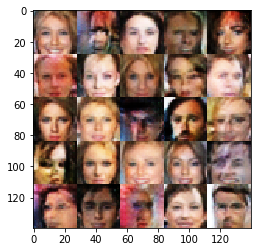

Epoch 1/1: 	 Batch 5110 -- 	 Discriminator Loss: 1.3257 	 Generator Loss: 0.7541
Epoch 1/1: 	 Batch 5120 -- 	 Discriminator Loss: 1.3450 	 Generator Loss: 0.7138
Epoch 1/1: 	 Batch 5130 -- 	 Discriminator Loss: 1.1081 	 Generator Loss: 1.0203
Epoch 1/1: 	 Batch 5140 -- 	 Discriminator Loss: 1.3229 	 Generator Loss: 0.7304
Epoch 1/1: 	 Batch 5150 -- 	 Discriminator Loss: 1.3492 	 Generator Loss: 0.7464
Epoch 1/1: 	 Batch 5160 -- 	 Discriminator Loss: 1.2416 	 Generator Loss: 0.7677
Epoch 1/1: 	 Batch 5170 -- 	 Discriminator Loss: 1.2593 	 Generator Loss: 0.7442
Epoch 1/1: 	 Batch 5180 -- 	 Discriminator Loss: 1.2761 	 Generator Loss: 0.8140
Epoch 1/1: 	 Batch 5190 -- 	 Discriminator Loss: 1.2536 	 Generator Loss: 0.7589
Epoch 1/1: 	 Batch 5200 -- 	 Discriminator Loss: 1.2740 	 Generator Loss: 0.8524


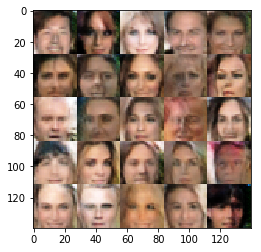

Epoch 1/1: 	 Batch 5210 -- 	 Discriminator Loss: 1.2390 	 Generator Loss: 0.8052
Epoch 1/1: 	 Batch 5220 -- 	 Discriminator Loss: 1.1862 	 Generator Loss: 0.9273
Epoch 1/1: 	 Batch 5230 -- 	 Discriminator Loss: 1.3036 	 Generator Loss: 0.7458
Epoch 1/1: 	 Batch 5240 -- 	 Discriminator Loss: 1.2905 	 Generator Loss: 0.7291
Epoch 1/1: 	 Batch 5250 -- 	 Discriminator Loss: 1.2143 	 Generator Loss: 0.8146
Epoch 1/1: 	 Batch 5260 -- 	 Discriminator Loss: 1.3873 	 Generator Loss: 0.6224
Epoch 1/1: 	 Batch 5270 -- 	 Discriminator Loss: 1.1894 	 Generator Loss: 0.8404
Epoch 1/1: 	 Batch 5280 -- 	 Discriminator Loss: 1.2821 	 Generator Loss: 0.7327
Epoch 1/1: 	 Batch 5290 -- 	 Discriminator Loss: 1.2820 	 Generator Loss: 0.7496
Epoch 1/1: 	 Batch 5300 -- 	 Discriminator Loss: 1.3981 	 Generator Loss: 0.6964


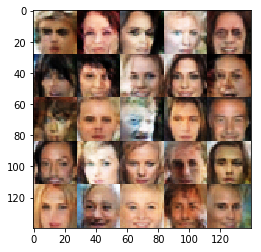

Epoch 1/1: 	 Batch 5310 -- 	 Discriminator Loss: 1.2798 	 Generator Loss: 0.8411
Epoch 1/1: 	 Batch 5320 -- 	 Discriminator Loss: 1.3336 	 Generator Loss: 0.7093
Epoch 1/1: 	 Batch 5330 -- 	 Discriminator Loss: 1.2618 	 Generator Loss: 0.8058
Epoch 1/1: 	 Batch 5340 -- 	 Discriminator Loss: 1.1888 	 Generator Loss: 0.7785
Epoch 1/1: 	 Batch 5350 -- 	 Discriminator Loss: 1.3005 	 Generator Loss: 0.7495
Epoch 1/1: 	 Batch 5360 -- 	 Discriminator Loss: 1.2862 	 Generator Loss: 0.7023
Epoch 1/1: 	 Batch 5370 -- 	 Discriminator Loss: 1.2388 	 Generator Loss: 0.8570
Epoch 1/1: 	 Batch 5380 -- 	 Discriminator Loss: 1.3047 	 Generator Loss: 0.7947
Epoch 1/1: 	 Batch 5390 -- 	 Discriminator Loss: 1.3462 	 Generator Loss: 0.6935
Epoch 1/1: 	 Batch 5400 -- 	 Discriminator Loss: 1.3568 	 Generator Loss: 0.6755


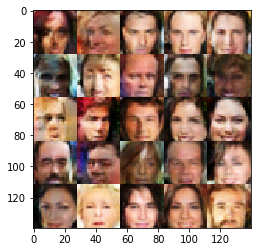

Epoch 1/1: 	 Batch 5410 -- 	 Discriminator Loss: 1.1410 	 Generator Loss: 0.9368
Epoch 1/1: 	 Batch 5420 -- 	 Discriminator Loss: 1.2250 	 Generator Loss: 0.8425
Epoch 1/1: 	 Batch 5430 -- 	 Discriminator Loss: 1.3669 	 Generator Loss: 0.7802
Epoch 1/1: 	 Batch 5440 -- 	 Discriminator Loss: 1.2714 	 Generator Loss: 0.8102
Epoch 1/1: 	 Batch 5450 -- 	 Discriminator Loss: 1.2768 	 Generator Loss: 0.7354
Epoch 1/1: 	 Batch 5460 -- 	 Discriminator Loss: 1.2380 	 Generator Loss: 0.8262
Epoch 1/1: 	 Batch 5470 -- 	 Discriminator Loss: 1.2722 	 Generator Loss: 0.7459
Epoch 1/1: 	 Batch 5480 -- 	 Discriminator Loss: 1.2233 	 Generator Loss: 0.7607
Epoch 1/1: 	 Batch 5490 -- 	 Discriminator Loss: 1.2203 	 Generator Loss: 0.7888
Epoch 1/1: 	 Batch 5500 -- 	 Discriminator Loss: 1.3020 	 Generator Loss: 0.7054


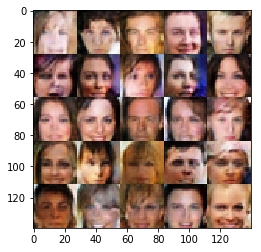

Epoch 1/1: 	 Batch 5510 -- 	 Discriminator Loss: 1.3106 	 Generator Loss: 0.7310
Epoch 1/1: 	 Batch 5520 -- 	 Discriminator Loss: 1.4652 	 Generator Loss: 0.6519
Epoch 1/1: 	 Batch 5530 -- 	 Discriminator Loss: 1.2630 	 Generator Loss: 0.7112
Epoch 1/1: 	 Batch 5540 -- 	 Discriminator Loss: 1.2230 	 Generator Loss: 0.8233
Epoch 1/1: 	 Batch 5550 -- 	 Discriminator Loss: 1.0902 	 Generator Loss: 1.3644
Epoch 1/1: 	 Batch 5560 -- 	 Discriminator Loss: 1.1897 	 Generator Loss: 0.7458
Epoch 1/1: 	 Batch 5570 -- 	 Discriminator Loss: 1.1963 	 Generator Loss: 0.8065
Epoch 1/1: 	 Batch 5580 -- 	 Discriminator Loss: 1.3344 	 Generator Loss: 0.7645
Epoch 1/1: 	 Batch 5590 -- 	 Discriminator Loss: 1.4223 	 Generator Loss: 0.7046
Epoch 1/1: 	 Batch 5600 -- 	 Discriminator Loss: 1.2662 	 Generator Loss: 0.8536


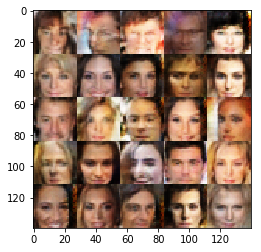

Epoch 1/1: 	 Batch 5610 -- 	 Discriminator Loss: 1.2223 	 Generator Loss: 0.8105
Epoch 1/1: 	 Batch 5620 -- 	 Discriminator Loss: 1.2386 	 Generator Loss: 0.8234
Epoch 1/1: 	 Batch 5630 -- 	 Discriminator Loss: 1.2896 	 Generator Loss: 0.8062
Epoch 1/1: 	 Batch 5640 -- 	 Discriminator Loss: 1.1949 	 Generator Loss: 0.8228
Epoch 1/1: 	 Batch 5650 -- 	 Discriminator Loss: 1.2584 	 Generator Loss: 0.8000
Epoch 1/1: 	 Batch 5660 -- 	 Discriminator Loss: 1.2670 	 Generator Loss: 0.8017
Epoch 1/1: 	 Batch 5670 -- 	 Discriminator Loss: 1.4234 	 Generator Loss: 0.6246
Epoch 1/1: 	 Batch 5680 -- 	 Discriminator Loss: 1.2168 	 Generator Loss: 0.8199
Epoch 1/1: 	 Batch 5690 -- 	 Discriminator Loss: 1.3072 	 Generator Loss: 0.6957
Epoch 1/1: 	 Batch 5700 -- 	 Discriminator Loss: 1.3124 	 Generator Loss: 0.7741


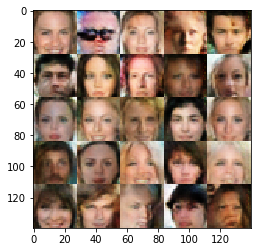

Epoch 1/1: 	 Batch 5710 -- 	 Discriminator Loss: 1.3139 	 Generator Loss: 0.7120
Epoch 1/1: 	 Batch 5720 -- 	 Discriminator Loss: 1.3866 	 Generator Loss: 0.6068
Epoch 1/1: 	 Batch 5730 -- 	 Discriminator Loss: 1.2866 	 Generator Loss: 0.8023
Epoch 1/1: 	 Batch 5740 -- 	 Discriminator Loss: 1.3453 	 Generator Loss: 0.6798
Epoch 1/1: 	 Batch 5750 -- 	 Discriminator Loss: 1.2917 	 Generator Loss: 0.8115
Epoch 1/1: 	 Batch 5760 -- 	 Discriminator Loss: 1.2605 	 Generator Loss: 0.7320
Epoch 1/1: 	 Batch 5770 -- 	 Discriminator Loss: 1.2011 	 Generator Loss: 0.8194
Epoch 1/1: 	 Batch 5780 -- 	 Discriminator Loss: 1.2538 	 Generator Loss: 0.7498
Epoch 1/1: 	 Batch 5790 -- 	 Discriminator Loss: 1.3106 	 Generator Loss: 0.7945
Epoch 1/1: 	 Batch 5800 -- 	 Discriminator Loss: 1.1625 	 Generator Loss: 0.8498


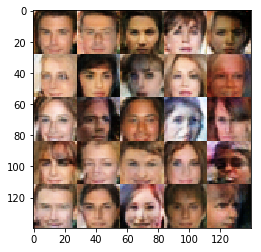

Epoch 1/1: 	 Batch 5810 -- 	 Discriminator Loss: 1.3003 	 Generator Loss: 0.7206
Epoch 1/1: 	 Batch 5820 -- 	 Discriminator Loss: 1.3204 	 Generator Loss: 0.6926
Epoch 1/1: 	 Batch 5830 -- 	 Discriminator Loss: 1.3205 	 Generator Loss: 0.7794
Epoch 1/1: 	 Batch 5840 -- 	 Discriminator Loss: 1.2727 	 Generator Loss: 0.7496
Epoch 1/1: 	 Batch 5850 -- 	 Discriminator Loss: 1.2803 	 Generator Loss: 0.6882
Epoch 1/1: 	 Batch 5860 -- 	 Discriminator Loss: 1.2156 	 Generator Loss: 0.8092
Epoch 1/1: 	 Batch 5870 -- 	 Discriminator Loss: 1.3005 	 Generator Loss: 0.7570
Epoch 1/1: 	 Batch 5880 -- 	 Discriminator Loss: 1.2537 	 Generator Loss: 0.7584
Epoch 1/1: 	 Batch 5890 -- 	 Discriminator Loss: 1.3247 	 Generator Loss: 0.6678
Epoch 1/1: 	 Batch 5900 -- 	 Discriminator Loss: 1.4379 	 Generator Loss: 0.6435


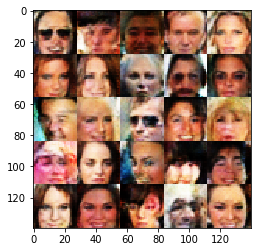

Epoch 1/1: 	 Batch 5910 -- 	 Discriminator Loss: 1.1808 	 Generator Loss: 0.8108
Epoch 1/1: 	 Batch 5920 -- 	 Discriminator Loss: 1.3159 	 Generator Loss: 0.8926
Epoch 1/1: 	 Batch 5930 -- 	 Discriminator Loss: 1.3316 	 Generator Loss: 0.7659
Epoch 1/1: 	 Batch 5940 -- 	 Discriminator Loss: 1.2721 	 Generator Loss: 0.7230
Epoch 1/1: 	 Batch 5950 -- 	 Discriminator Loss: 1.3825 	 Generator Loss: 0.6556
Epoch 1/1: 	 Batch 5960 -- 	 Discriminator Loss: 1.2296 	 Generator Loss: 0.8150
Epoch 1/1: 	 Batch 5970 -- 	 Discriminator Loss: 1.2531 	 Generator Loss: 0.8609
Epoch 1/1: 	 Batch 5980 -- 	 Discriminator Loss: 1.2750 	 Generator Loss: 0.7568
Epoch 1/1: 	 Batch 5990 -- 	 Discriminator Loss: 1.4293 	 Generator Loss: 0.7386
Epoch 1/1: 	 Batch 6000 -- 	 Discriminator Loss: 1.1738 	 Generator Loss: 0.8716


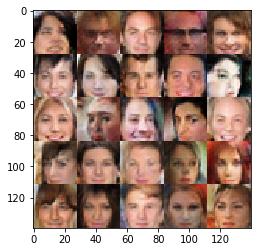

Epoch 1/1: 	 Batch 6010 -- 	 Discriminator Loss: 1.1510 	 Generator Loss: 0.8550
Epoch 1/1: 	 Batch 6020 -- 	 Discriminator Loss: 1.2275 	 Generator Loss: 0.8742
Epoch 1/1: 	 Batch 6030 -- 	 Discriminator Loss: 1.3067 	 Generator Loss: 0.8183
Epoch 1/1: 	 Batch 6040 -- 	 Discriminator Loss: 1.2167 	 Generator Loss: 0.7766
Epoch 1/1: 	 Batch 6050 -- 	 Discriminator Loss: 1.2955 	 Generator Loss: 0.8109
Epoch 1/1: 	 Batch 6060 -- 	 Discriminator Loss: 1.3780 	 Generator Loss: 0.7163
Epoch 1/1: 	 Batch 6070 -- 	 Discriminator Loss: 1.3040 	 Generator Loss: 0.8239
Epoch 1/1: 	 Batch 6080 -- 	 Discriminator Loss: 1.2776 	 Generator Loss: 0.7201
Epoch 1/1: 	 Batch 6090 -- 	 Discriminator Loss: 1.1929 	 Generator Loss: 0.8391
Epoch 1/1: 	 Batch 6100 -- 	 Discriminator Loss: 1.2111 	 Generator Loss: 0.8732


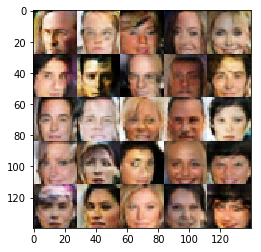

Epoch 1/1: 	 Batch 6110 -- 	 Discriminator Loss: 1.2665 	 Generator Loss: 0.7971
Epoch 1/1: 	 Batch 6120 -- 	 Discriminator Loss: 1.4236 	 Generator Loss: 0.6937
Epoch 1/1: 	 Batch 6130 -- 	 Discriminator Loss: 1.2710 	 Generator Loss: 0.7590
Epoch 1/1: 	 Batch 6140 -- 	 Discriminator Loss: 1.3025 	 Generator Loss: 0.7531
Epoch 1/1: 	 Batch 6150 -- 	 Discriminator Loss: 1.2869 	 Generator Loss: 0.7491
Epoch 1/1: 	 Batch 6160 -- 	 Discriminator Loss: 1.2733 	 Generator Loss: 0.8408
Epoch 1/1: 	 Batch 6170 -- 	 Discriminator Loss: 1.2669 	 Generator Loss: 0.8129
Epoch 1/1: 	 Batch 6180 -- 	 Discriminator Loss: 1.3168 	 Generator Loss: 0.6554
Epoch 1/1: 	 Batch 6190 -- 	 Discriminator Loss: 1.2661 	 Generator Loss: 0.7806
Epoch 1/1: 	 Batch 6200 -- 	 Discriminator Loss: 1.2715 	 Generator Loss: 0.7619


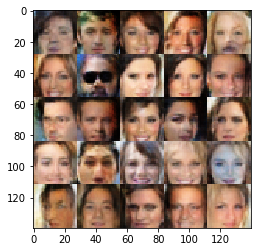

Epoch 1/1: 	 Batch 6210 -- 	 Discriminator Loss: 1.3104 	 Generator Loss: 0.8366
Epoch 1/1: 	 Batch 6220 -- 	 Discriminator Loss: 1.2000 	 Generator Loss: 0.8123
Epoch 1/1: 	 Batch 6230 -- 	 Discriminator Loss: 1.2226 	 Generator Loss: 0.8121
Epoch 1/1: 	 Batch 6240 -- 	 Discriminator Loss: 1.2820 	 Generator Loss: 0.8549
Epoch 1/1: 	 Batch 6250 -- 	 Discriminator Loss: 1.2449 	 Generator Loss: 0.8366
Epoch 1/1: 	 Batch 6260 -- 	 Discriminator Loss: 1.1769 	 Generator Loss: 0.7825
Epoch 1/1: 	 Batch 6270 -- 	 Discriminator Loss: 1.3006 	 Generator Loss: 0.7777
Epoch 1/1: 	 Batch 6280 -- 	 Discriminator Loss: 0.8460 	 Generator Loss: 1.4647
Epoch 1/1: 	 Batch 6290 -- 	 Discriminator Loss: 1.2090 	 Generator Loss: 0.7178
Epoch 1/1: 	 Batch 6300 -- 	 Discriminator Loss: 1.5087 	 Generator Loss: 0.4757


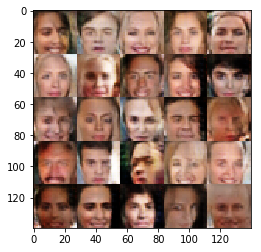

Epoch 1/1: 	 Batch 6310 -- 	 Discriminator Loss: 1.2418 	 Generator Loss: 0.9298
Epoch 1/1: 	 Batch 6320 -- 	 Discriminator Loss: 1.3733 	 Generator Loss: 0.7006
Epoch 1/1: 	 Batch 6330 -- 	 Discriminator Loss: 1.1668 	 Generator Loss: 0.7919


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.